**ИССЛЕДОВАНИЕ ГРАЖДАНСКОГО ОБЩЕСТВА-УЯЗВИМЫЕ ГРУППЫ**

1. В работе использовались данные, представленные в рамках проекта, а также их обновленные версии и данные, взятые с источников, таких как https://www.fedstat.ru/, https://showdata.gks.ru/ и ресурсы ведомств.
2. Данные подготовлены на год, в котором есть данные всех признаков -2020. 
3. По техническим причинам проект представлен в "облегченном" варианте, где количество графики минимизировано в пользу визуализации конечных результатов кластеризации.

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import re
from scipy import stats

from sklearn import mixture
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import model_selection
import seaborn as sns
from matplotlib import cm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

* создаем словарь для унифицикации названий регионов РФ

In [2]:
subject_names = {
    'алтайск': 'Алтайский край',
    'амур': 'Амурская область',
    'архангел': 'Архангельская область без округов',
    'астрахан':  'Астраханская область',
    'белгород':  'Белгородская область',
    'брянск': 'Брянская область',
    'владимир': 'Владимирская область',
    'волгоград':  'Волгоградская область',
    'вологод': 'Вологодская область',
    'воронеж': 'Воронежская область',
    'еврей':  'Еврейская автономная область',
    'забайкал': 'Забайкальский край',
    'иванов': 'Ивановская область',
    'иркутск':  'Иркутская область',
    'кабардин': 'Кабардино-Балкарская Республика',
    'калининград': 'Калининградская область',
    'калуж': 'Калужская область',
    'камчатск(?!о)': 'Камчатский край',
    'карач': 'Карачаево-Черкесская Республика',
    'кемеров': 'Кемеровская область',
    'киров': 'Кировская область',
    'костром': 'Костромская область',
    'краснодар': 'Краснодарский край',
    'краснояр': 'Красноярский край',
    'курган': 'Курганская область',
    'курск': 'Курская область',
    'ленин': 'Ленинградская область',
    'липецк': 'Липецкая область',
    'магадан': 'Магаданская область',
    'москов': 'Московская область',
    'мурман': 'Мурманская область',
    '(?<!-)ненец': 'Ненецкий автономный округ',
    'нижегород': 'Нижегородская область',
    'новгород': 'Новгородская область',
    'новосибир': 'Новосибирская область',
    '(?<!т)омск': 'Омская область',
    'оренбург': 'Оренбургская область',
    'орлов': 'Орловская область',
    'пенз': 'Пензенская область',
    'пермск(?!о)': 'Пермский край',
    'примор': 'Приморский край',
    'псков': 'Псковская область',
    'адыг': 'Республика Адыгея',
    'алтай(?!с)': 'Республика Алтай',
    'башк': 'Республика Башкортостан',
    'бурят(?!с)': 'Республика Бурятия',
    'дагестан': 'Республика Дагестан',
    'ингуш': 'Республика Ингушетия',
    'калмык': 'Республика Калмыкия',
    'карел': 'Республика Карелия',
    'коми(?![-н])': 'Республика Коми',
    'крым(?!с)': 'Республика Крым',
    'мари': 'Республика Марий Эл',
    'морд': 'Республика Мордовия',
    'саха(?!л)': 'Республика Саха (Якутия)',
    'якут': 'Республика Саха (Якутия)',
    'осет': 'Республика Северная Осетия-Алания',
    'татар': 'Республика Татарстан',
    'тыва': 'Республика Тыва',
    'хакас': 'Республика Хакасия',
    'ростов': 'Ростовская область',
    'рязан': 'Рязанская область',
    'самар': 'Самарская область',
    'саратов': 'Саратовская область',
    'сахалин': 'Сахалинская область',
    'свердлов': 'Свердловская область',
    'смолен': 'Смоленская область',
    'ставрополь': 'Ставропольский край',
    'тамбов': 'Тамбовская область',
    'твер': 'Тверская область',
    'томск': 'Томская область',
    'туль': 'Тульская область',
    'тюмен': 'Тюменская область без округов',
    'удмурт': 'Удмуртская Республика',
    'ульянов': 'Ульяновская область',
    'хабаровск': 'Хабаровский край',
    'хант': 'Ханты-Мансийский автономный округ - Югра',
    'челябинск': 'Челябинская область',
    'чечен': 'Чеченская Республика',
    'чуваш': 'Чувашская Республика',
    'чукот': 'Чукотский автономный округ',
    'ямал': 'Ямало-Ненецкий автономный округ',
    'ярослав': 'Ярославская область',
    'москва': 'Москва',
    'петербург': 'Санкт-Петербург',
    'севастополь': 'Севастополь'}

In [3]:
def get_federation(
    df, subject_names, names_to_drop=None, region_col='region'):
          
    def get_subject_names(x):
            
        for key, value in subject_names.items():
            x = re.sub('[\(].*?[\)]', '', x)  
            if re.search(key, x.lower()):
                return value
        return None
    
    if names_to_drop is None:
        names_to_drop = []
    df = df[~df[region_col].isin(names_to_drop)].copy()
    df[region_col] = df[region_col].apply(get_subject_names)
    return (df.dropna(subset=region_col)
            .set_index(region_col).sort_index()) 

* среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата

In [7]:
def get_per_capita_cash_income(file,sheet):
    
    per_capita_cash_income = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx',sheet_name=sheet, usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    per_capita_cash_income = get_federation(per_capita_cash_income, subject_names, names_to_drop)
    return per_capita_cash_income
per_capita_cash_income = 'data/cash_real_income_wages_2015_2020.xlsx'
per_capita_cash_income = get_per_capita_cash_income(per_capita_cash_income, 0)
per_capita_cash_income.columns=['per_capita_cash_income_2020']

print(per_capita_cash_income.shape)
per_capita_cash_income.head()

(85, 1)


,per_capita_cash_income_2020
region,
Алтайский край,23864.0
Амурская область,35499.0
Архангельская область без округов,34852.0
Астраханская область,25199.0
Белгородская область,32841.0


In [8]:
def get_real_incomes(file, sheet):
    
    file = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx',sheet_name=sheet,usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file = get_federation(file, subject_names, names_to_drop)
    return file
real_incomes = 'data/cash_real_income_wages_2015_2020.xlsx'
real_incomes = get_real_incomes(real_incomes, 1)
real_incomes.columns=['real_incomes_2020']

print(real_incomes.shape)
real_incomes.head()

(85, 1)


,real_incomes_2020
region,
Алтайский край,95.5
Амурская область,100.3
Архангельская область без округов,98.4
Астраханская область,97.1
Белгородская область,98.1


In [9]:
def get_formal_wage_paid(file, sheet):
    
    file = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx',sheet_name=sheet,usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file = get_federation(file, subject_names, names_to_drop)
    return file
formal_wage_paid = 'data/cash_real_income_wages_2015_2020.xlsx'
formal_wage_paid = get_formal_wage_paid(formal_wage_paid, 2)
formal_wage_paid.columns=['formal_wage_paid_2020']

print(formal_wage_paid.shape)
formal_wage_paid.head()

(85, 1)


,formal_wage_paid_2020
region,
Алтайский край,30072.0
Амурская область,52430.0
Архангельская область без округов,52779.0
Астраханская область,38885.0
Белгородская область,37442.0


In [10]:
def get_real_pay(file, sheet):
    
    file = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx',sheet_name=sheet,usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file = get_federation(file, subject_names, names_to_drop)
    return file
real_pay = 'data/cash_real_income_wages_2015_2020.xlsx'
real_pay = get_real_pay(real_pay, 3)
real_pay.columns=['real_pay_2020']

print(real_pay.shape)
real_pay.head()

(85, 1)


,real_pay_2020
region,
Алтайский край,103.8
Амурская область,105.2
Архангельская область без округов,102.9
Астраханская область,104.5
Белгородская область,104.8


* число умерших на первом году жизни детей за год

In [11]:
def get_mortality(file):
    
    file = pd.read_excel('data/23220000100040200001_Число_умерших_на_первом_году_жизни_детей_за_год.xlsx', skiprows=1, usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file
mortality = 'data/23220000100040200001_Число_умерших_на_первом_году_жизни_детей_за_год.xlsx'
mortality = get_mortality(mortality)
mortality.columns=['mortality_2020']

print(mortality.shape)
mortality.head()

(85, 1)


,mortality_2020
region,
Алтайский край,97.0
Амурская область,42.0
Архангельская область без округов,29.0
Астраханская область,64.0
Белгородская область,47.0


* число родившихся (без мертворожденных) за год

In [12]:
def get_newborn(file):
    
    file = pd.read_excel('data/23210000100020200001_Число_родившихся_(без_мертворожденных)_за_год.xlsx', skiprows=1, usecols='A,G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file.drop (index=[ 0 , 1])
    file = get_federation(file, subject_names, names_to_drop)
    return file
newborn = 'data/23210000100020200001_Число_родившихся_(без_мертворожденных)_за_год.xlsx'
newborn = get_newborn(newborn)
newborn.columns=['newborn_2020']

print(newborn.shape)
newborn.head()

(85, 1)


,newborn_2020
region,
Алтайский край,19840.0
Амурская область,7800.0
Архангельская область без округов,8886.0
Астраханская область,10956.0
Белгородская область,12294.0


* число зарегистрированных больных с впервые в жизни установленным диагнозом алкоголизма

In [15]:
alc_20 = pd.read_excel('data/data_alc_20.xls', header=2)

def get_alc(file):
    
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

alc_20 = get_alc(alc_20)
alc_20.columns=['alc_2020']

print(alc_20.shape)
alc_20.head()

(85, 1)


,alc_2020
region,
Алтайский край,1357
Амурская область,530
Архангельская область без округов,665
Астраханская область,75
Белгородская область,612


* число зарегистрированных больных с впервые в жизни установленным диагнозом наркомании

In [16]:
nar_20 = pd.read_excel('data/datanar20.xls', header=2)


def get_nar(file):
    
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

nar_20 = get_nar(nar_20)
nar_20.columns=['nar_2020']

print(nar_20.shape)
nar_20.head()

(85, 1)


,nar_2020
region,
Алтайский край,229
Амурская область,128
Архангельская область без округов,64
Астраханская область,1
Белгородская область,48


* число зарегистрированных врожденных аномалий у больных с диагнозом, установленном впервые

In [17]:
def get_anomalies(file):
    
    file = pd.read_excel('data/22420000100050200001_Число_зарегистрированных_заболеваний_у_больных_с_диагнозом,_установленном_вперв.xlsx',header=1, usecols='A,F')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file.drop (index=[ 0 , 1])
    file = get_federation(file, subject_names, names_to_drop)
    return file

anomalies = 'data/22420000100050200001_Число_зарегистрированных_заболеваний_у_больных_с_диагнозом,_установленном_вперв.xlsx'
anomalies = get_anomalies(anomalies)
anomalies.columns=['anomalies_2020']

print(anomalies.shape)
anomalies.head()

(85, 1)


,anomalies_2020
region,
Алтайский край,341.0
Амурская область,53.0
Архангельская область без округов,449.0
Астраханская область,212.0
Белгородская область,498.0


* удельный вес расходов на соцполитику в общем объеме расходов бюджетов субъектов (%)

In [18]:
def get_social_expenses(file):
    
    file = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx', usecols='A,G')
    file = get_federation(file, subject_names)
    return file

social_expenses = 'data/welfare_expense_share_2015_2020.xlsx'
social_expenses = get_social_expenses(social_expenses)
social_expenses.columns=['soc_ex_2020']

print(social_expenses.shape)
social_expenses.head()

(85, 1)


,soc_ex_2020
region,
Алтайский край,29.7
Амурская область,21.7
Архангельская область без округов,21.4
Астраханская область,31.4
Белгородская область,16.1


* распределение малоимущего населения по социально-демографическим группам (%)

In [19]:
poverty_socdem_20 = pd.read_excel('data/mal_20.xls', header=2,usecols='A,C:E')

def get_poverty_socdem(file):
    
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

poverty_socdem_20 = get_poverty_socdem(poverty_socdem_20)
poverty_socdem_20 = poverty_socdem_20.fillna(poverty_socdem_20.mean ())
poverty_socdem_20.columns=['child_need_under_16_2020', 'people_need_over_working_age_2020','people_need_working_age_2020']

print(poverty_socdem_20.shape)
poverty_socdem_20.head()

(85, 3)


,child_need_under_16_2020,people_need_over_working_age_2020,people_need_working_age_2020
region,,,
Алтайский край,31.400000,9.200000,59.400000
Амурская область,38.400000,4.700000,56.900000
Архангельская область без округов,28.500000,7.200000,64.300000
Астраханская область,42.100000,5.500000,52.400000
Белгородская область,39.016438,5.045205,55.945205


* число абортов, включая мини-аборты

In [20]:
def get_abort(file):
    
    file = pd.read_excel('data/22412000100010200001_Число_абортов,_включая_мини-аборты_-_всего.xlsx',header=1, usecols='A,E')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

abort = 'data/22412000100010200001_Число_абортов,_включая_мини-аборты_-_всего.xlsx'
abort = get_abort(abort)
abort.columns=['abort_2020']

print(abort.shape)
abort.head()

(85, 1)


,abort_2020
region,
Алтайский край,8488.0
Амурская область,4276.0
Архангельская область без округов,5463.0
Астраханская область,3520.0
Белгородская область,3100.0


* оборот розничной торговли на душу населения

In [21]:
def get_retail_turnover_per_capita(file):
    
    file = pd.read_excel('data/13411000200080200001_Оборот_розничной_торговли_на_душу_населения.xlsx',header=1, usecols='A, G')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

retail_turnover_per_capita = 'data/13411000200080200001_Оборот_розничной_торговли_на_душу_населения.xlsx'
retail_turnover_per_capita = get_retail_turnover_per_capita(retail_turnover_per_capita)
retail_turnover_per_capita.columns=['ret_turn_per_capita_2020_(rub)']

print(retail_turnover_per_capita.shape)
retail_turnover_per_capita.head()

(85, 1)


,ret_turn_per_capita_2020_(rub)
region,
Алтайский край,153605.00
Амурская область,245232.99
Архангельская область без округов,250032.99
Астраханская область,174526.99
Белгородская область,237076.00


* общая площадь жилых помещений на одного жителя

In [22]:
def get_housting(file):
    
    file = pd.read_excel('data/Общая площадь жилых помещений на одного жителя_15_20.xls',header=2, usecols='A,H')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

housting = 'data/Общая площадь жилых помещений на одного жителя_15_20.xls'
housting = get_housting(housting)
housting.columns=['housting_2020']

print(housting.shape)
housting.head()

(85, 1)


,housting_2020
region,
Алтайский край,25.31
Амурская область,26.04
Архангельская область без округов,28.86
Астраханская область,25.03
Белгородская область,32.93


* смертность от самоубийств

In [23]:
def get_suicid(file):
    
    file = pd.read_excel('data/23220000400060200006_Смертность_от_самоубийств_(3_4_2_).xlsx',header=1, usecols='A,E')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

suicid = 'data/23220000400060200006_Смертность_от_самоубийств_(3_4_2_).xlsx'
suicid = get_suicid(suicid)
suicid.columns=['suicid_2020']

print(suicid.shape)
suicid.head()

(85, 1)


,suicid_2020
region,
Алтайский край,22.3
Амурская область,29.0
Архангельская область без округов,26.0
Астраханская область,2.6
Белгородская область,9.4


* число зарегистрированных больных с впервые в жизни установленным диагнозом ВИЧ-инфекции

In [24]:
def get_HIV(file):
    
    file = pd.read_excel('data/Число выявленных случаев ВИЧ.xls',header=2, usecols='A,E')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

HIV = 'data/Число выявленных случаев ВИЧ.xls'
HIV = get_HIV(HIV)

HIV.columns=['HIV_2020']
print(HIV.shape)
HIV.head()

(85, 1)


,HIV_2020
region,
Алтайский край,1892
Амурская область,143
Архангельская область без округов,228
Астраханская область,167
Белгородская область,224


* валовой региональный продукт на душу населения

In [25]:
def get_grp(file):
    
    file = pd.read_excel('data/За_период,_21220000200200200001_Валовой_региональный_продукт_на_душу_населения.xlsx',header=1, usecols='A, I')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

grp = 'data/За_период,_21220000200200200001_Валовой_региональный_продукт_на_душу_населения.xlsx'
grp = get_grp(grp)
grp.columns=['grp_2020']

print(grp.shape)
grp.head()

(85, 1)


,grp_2020
region,
Алтайский край,291156.89
Амурская область,571362.10
Архангельская область без округов,514200.39
Астраханская область,526950.90
Белгородская область,646569.00


* численность постоянного населения в среднем за год

In [26]:
def get_population(file):
    
    file = pd.read_excel('data/23110000100040200001_Численность_постоянного_населения_в_среднем_за_год.xlsx', header=1,usecols='A, I')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

population = 'data/23110000100040200001_Численность_постоянного_населения_в_среднем_за_год.xlsx'
population = get_population(population)
population.columns=['pop_2020']

print(population.shape)
population.head()

(85, 1)


,pop_2020
region,
Алтайский край,2306753.0
Амурская область,785944.0
Архангельская область без округов,1087542.0
Астраханская область,1001780.0
Белгородская область,1545205.0


* число амбулаторно-поликлинических организаций

In [27]:
def get_polyclinic(file):
    
    file = pd.read_excel('data/Apo.xls', header=1,usecols='A, R')
    file = file.drop (index= 0)
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

polyclinic = 'data/Apo.xls'
polyclinic = get_polyclinic(polyclinic)
polyclinic.columns=['p_clinic_2020']

print(polyclinic.shape)
polyclinic.head()

(85, 1)


,p_clinic_2020
region,
Алтайский край,208
Амурская область,164
Архангельская область без округов,237
Астраханская область,169
Белгородская область,160


* число больничных организаций 

In [28]:
def get_hospital(file):
    
    file = pd.read_excel('data/Chislo_bolnich_organiz.xls', header=2,usecols='A, R')
    file = file.drop (index= 0) 
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

hospital = 'data/Chislo_bolnich_organiz.xls'
hospital = get_hospital(hospital)
hospital.columns=['hosp_2020']

print(hospital.shape)
hospital.head()

(85, 1)


,hosp_2020
region,
Алтайский край,125
Амурская область,39
Архангельская область без округов,58
Астраханская область,34
Белгородская область,42


* численность инвалидов по группам инвалидности

In [29]:
def get_invalid(file):
    
    file = pd.read_excel('data/pi_1.3.xlsx', header=4, skipfooter=1, usecols='A, V:Y')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

invalid = 'data/pi_1.3.xlsx'
invalid = get_invalid(invalid)
invalid.columns = ['1_group_invalid_2020','2_group_invalid_2020', '3_group_invalid_2020','child_invalid_2020']

print(invalid.shape)
invalid.head()

(85, 4)


,1_group_invalid_2020,2_group_invalid_2020,3_group_invalid_2020,child_invalid_2020
region,,,,
Алтайский край,25483,68406,79979,10789
Амурская область,13230,30151,21303,4248
Архангельская область без округов,12847,30784,41714,4606
Астраханская область,7502,17234,18808,4069
Белгородская область,15183,106995,77988,5522


* численность населения с денежными доходами ниже границы бедности (величины прожиточного минимума)(%)

In [30]:
def get_poverty(file):
    
    file = pd.read_excel('data/tab2-1.xlsx', 'по РФ и субъектам РФ 1995-2022', header=2,skipfooter=5,usecols='A, AA')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

poverty = 'data/tab2-1.xlsx', 'по РФ и субъектам РФ 1995-2022'
poverty = get_poverty(poverty)
poverty.columns=['poverty_2020']

print(poverty.shape)
poverty.head()

(85, 1)


,poverty_2020
region,
Алтайский край,17.5
Амурская область,15.2
Архангельская область без округов,12.3
Астраханская область,15.6
Белгородская область,7.2


* уровень безработицы населения в возрасте 15 лет и старше (%)

In [31]:
def get_unemployed(file):
    
    file = pd.read_excel('data/trud-3_15-s.xlsx', '2', header=4, skipfooter=1, usecols='A,E')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

unemployed = 'data/trud-3_15-s.xlsx', '2'
unemployed = get_unemployed(unemployed)
unemployed.columns=['unemployed_2020']

print(unemployed.shape)
unemployed.head()

(85, 1)


,unemployed_2020
region,
Алтайский край,5.9
Амурская область,6.0
Архангельская область без округов,7.3
Астраханская область,7.9
Белгородская область,4.9


* смертность от новообразований (в том числе злокачественных)

In [32]:
def get_death_cancer(file):
    
    file = pd.read_excel('data/23220000400060200014_Смертность_от_новообразований_(в_том_числе_злокачественных).xlsx', header=1, usecols='A,I')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

death_cancer = 'data/23220000400060200014_Смертность_от_новообразований_(в_том_числе_злокачественных).xlsx'
death_cancer = get_death_cancer(death_cancer)
death_cancer.columns=['death_cancer_2020']

print(death_cancer.shape)
death_cancer.head()

(85, 1)


,death_cancer_2020
region,
Алтайский край,229.7
Амурская область,232.2
Архангельская область без округов,241.2
Астраханская область,189.2
Белгородская область,179.9


* число разводов за год

In [33]:
def get_divorce(file):
    
    file = pd.read_excel('data/23240000100030200001_Число_разводов_за_год.xlsx', header=1, usecols='A,I')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

divorce = 'data/23240000100030200001_Число_разводов_за_год.xlsx'
divorce = get_divorce(divorce)
divorce.columns=['divorce_2020']

print(divorce.shape)
divorce.head()

(85, 1)


,divorce_2020
region,
Алтайский край,10030.99
Амурская область,3706.00
Архангельская область без округов,4384.00
Астраханская область,4095.00
Белгородская область,6345.00


* смертность от болезней системы кровообращения


In [34]:
def get_death_circulatory_system(file):
    
    file = pd.read_excel('data/23220000400060200013_Смертность_от_болезней_системы_кровообращения.xlsx', header=1, usecols='A,I')
    file = file.drop (index= 0 )
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

death_circulatory_system = 'data/23220000400060200013_Смертность_от_болезней_системы_кровообращения.xlsx'
death_circulatory_system = get_death_circulatory_system(death_circulatory_system)
death_circulatory_system.columns=['death_cir_syst_2020']

print(death_circulatory_system.shape)
death_circulatory_system.head()

(85, 1)


,death_cir_syst_2020
region,
Алтайский край,707.30
Амурская область,641.79
Архангельская область без округов,793.09
Астраханская область,641.49
Белгородская область,669.60


* смертность от туберкулеза

In [35]:
def get_death_tuberculosis(file):
    
    file = pd.read_excel('data/23220000400060200011_Смертность_от_туберкулеза.xlsx', header=1, usecols='A,I')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

death_tuberculosis = 'data/23220000400060200011_Смертность_от_туберкулеза.xlsx'
death_tuberculosis = get_death_tuberculosis(death_tuberculosis)
death_tuberculosis.columns=['death_tub_2020']

print(death_tuberculosis.shape)
death_tuberculosis.head()

(85, 1)


,death_tub_2020
region,
Алтайский край,12.4
Амурская область,12.0
Архангельская область без округов,1.8
Астраханская область,11.2
Белгородская область,0.4


* численность сирот, оставшихся без попечения родителей в Домах ребенка

In [36]:
def get_orphans(file):
    
    file = pd.read_excel('data/Число воспитанников в домах ребенка.xls',header=3,usecols='A,F')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

orphans = 'data/Число воспитанников в домах ребенка.xls'
orphans = get_orphans(orphans)
orphans.columns=['orphans_2020']

print(orphans.shape)
orphans.head()

(85, 1)


,orphans_2020
region,
Алтайский край,647
Амурская область,567
Архангельская область без округов,1034
Астраханская область,579
Белгородская область,413


* численность выявленных пациентов с впервые в жизни установленным диагнозом сифилисом

In [37]:
def get_syphilis(file):
    
    file = pd.read_excel('data/Число выявленных впервые случаев сифилиса.xls',header=3, usecols='A, F')
    names_to_drop = ['Архангельская область', 'Тюменская область']
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names, names_to_drop)
    return file

syphilis = 'data/Число выявленных впервые случаев сифилиса.xls'
syphilis = get_syphilis(syphilis)
syphilis.columns=['syphilis_2020']

print(syphilis.shape)
syphilis.head()

(85, 1)


,syphilis_2020
region,
Алтайский край,165
Амурская область,139
Архангельская область без округов,243
Астраханская область,93
Белгородская область,23


* численность выявленных пациентов с впервые в жизни установленным диагнозом гонорея

In [38]:
def get_gonorrhea(file):
    
    file = pd.read_excel('data/Число выявленных впервые случаев гонореи.xls',header=1, usecols='C,F')
    file = file.drop (index= 0)
    file.rename({'Unnamed: 2': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names)
    return file

gonorrhea = 'data/Число выявленных впервые случаев гонореи.xls'
gonorrhea = get_gonorrhea(gonorrhea)
gonorrhea.columns=['gonor_2020']

print(gonorrhea.shape)
gonorrhea.head()

(85, 1)


,gonor_2020
region,
Алтайский край,66
Амурская область,138
Архангельская область без округов,76
Астраханская область,107
Белгородская область,18


* численность выявленных пациентов с впервые в жизни установленным диагнозом активного туберкулеза

In [39]:
def get_active_tuberculosis(file):
    
    file = pd.read_excel('data/Численность_выявленных_пациентов__с_впервые_в_жизни_установленным_диагнозом_активного туберкулеза.xls', header=2, usecols='A, E')
    file = file.drop (index= 0)
    file.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names)
    return file

active_tuberculosis = 'data/Численность_выявленных_пациентов__с_впервые_в_жизни_установленным_диагнозом_активного туберкулеза.xls'
active_tuberculosis = get_active_tuberculosis(active_tuberculosis)
active_tuberculosis.columns=['active_tub_2020']

print(active_tuberculosis.shape)
active_tuberculosis.head()

(85, 1)


,active_tub_2020
region,
Алтайский край,1314
Амурская область,374
Архангельская область без округов,163
Астраханская область,602
Белгородская область,183


* сведения о преступлениях, совершенных отдельными категориями лиц

In [40]:
crimes_2020 = pd.read_excel('data/4-EGS_Razdel_4_122020.xls', 'Строка 1', header=10,skipfooter=9,usecols='B:D, J,K')

def get_crimes(file):
    
    file = file.drop (index=[ 0 , 1 , 2 ])
    file.rename({'Unnamed: 1': 'region'}, axis=1, inplace=True)
    file = get_federation(file, subject_names)
    return file

crimes_2020 = get_crimes(crimes_2020)
crimes_2020.columns=['commit_minors_2020','recidivist_2020', 'crime_under_alcohol_2020','crime_under_narc_2020']

print(crimes_2020.shape)
crimes_2020.head()

(85, 4)


,commit_minors_2020,recidivist_2020,crime_under_alcohol_2020,crime_under_narc_2020
region,,,,
Алтайский край,887,15400,9396,46
Амурская область,431,6001,3123,108
Архангельская область без округов,551,6569,4011,31
Астраханская область,343,5395,2534,70
Белгородская область,219,4599,2251,49


* региональная промышленность

In [41]:
regional_production = pd.read_csv('data/regional_production_2017_2020.csv')
regional_production.drop(['production_field', '2017','2018', '2019'], axis= 1 , inplace= True)
names_to_drop = ['Архангельская область', 'Тюменская область']
regional_production = regional_production.drop (index=[0,1])   
regional_production = get_federation(regional_production, subject_names, names_to_drop)
regional_production_2020 = regional_production.groupby('region')['2020'].sum().reset_index()
regional_production_2020.set_index('region', inplace=True)
regional_production_2020.columns=['reg_prod_2020']
regional_production_2020.head()

,reg_prod_2020
region,
Алтайский край,8.524434e+08
Амурская область,4.045765e+08
Архангельская область без округов,1.854125e+09
Астраханская область,7.245978e+08
Белгородская область,1.948294e+09


In [42]:
final = [per_capita_cash_income,real_incomes,formal_wage_paid,real_pay,mortality,newborn,alc_20,\
nar_20,anomalies,social_expenses,poverty_socdem_20,abort,retail_turnover_per_capita,housting,suicid,HIV,grp,population,\
polyclinic,hospital,invalid,poverty,unemployed,death_cancer,divorce,death_circulatory_system,death_tuberculosis,orphans,syphilis,gonorrhea,active_tuberculosis,crimes_2020,regional_production_2020]

final_df = reduce(lambda left,right: pd.merge(left,right,on=['region'],
 how='outer'), final)

In [43]:
final_df.to_csv (r'data/social.csv')

In [2]:
social= pd.read_csv('data/social.csv')

In [3]:
social_1 = social.set_index('region')

In [47]:
display(social_1.info())
social_1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   per_capita_cash_income_2020        85 non-null     float64
 1   real_incomes_2020                  85 non-null     float64
 2   formal_wage_paid_2020              85 non-null     float64
 3   real_pay_2020                      85 non-null     float64
 4   mortality_2020                     85 non-null     float64
 5   newborn_2020                       85 non-null     float64
 6   alc_2020                           85 non-null     int64  
 7   nar_2020                           85 non-null     int64  
 8   anomalies_2020                     85 non-null     float64
 9   soc_ex_2020                        85 non-null     float64
 10  child_need_under_16_2020           85 non-null     float64
 11  people_need_over_working_age_2020  

None

,per_capita_cash_income_2020,real_incomes_2020,formal_wage_paid_2020,real_pay_2020,mortality_2020,newborn_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,...,death_tub_2020,orphans_2020,syphilis_2020,gonor_2020,active_tub_2020,commit_minors_2020,recidivist_2020,crime_under_alcohol_2020,crime_under_narc_2020,reg_prod_2020
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,95.5,30072.0,103.8,97.0,19840.0,1357,229,341.0,29.7,...,12.4,647,165,66,1314,887,15400,9396,46,8.524434e+08
Амурская область,35499.0,100.3,52430.0,105.2,42.0,7800.0,530,128,53.0,21.7,...,12.0,567,139,138,374,431,6001,3123,108,4.045765e+08
Архангельская область без округов,34852.0,98.4,52779.0,102.9,29.0,8886.0,665,64,449.0,21.4,...,1.8,1034,243,76,163,551,6569,4011,31,1.854125e+09
Астраханская область,25199.0,97.1,38885.0,104.5,64.0,10956.0,75,1,212.0,31.4,...,11.2,579,93,107,602,343,5395,2534,70,7.245978e+08
Белгородская область,32841.0,98.1,37442.0,104.8,47.0,12294.0,612,48,498.0,16.1,...,0.4,413,23,18,183,219,4599,2251,49,1.948294e+09


In [48]:
social_1.isnull().sum()

per_capita_cash_income_2020          0
real_incomes_2020                    0
formal_wage_paid_2020                0
real_pay_2020                        0
mortality_2020                       0
newborn_2020                         0
alc_2020                             0
nar_2020                             0
anomalies_2020                       0
soc_ex_2020                          0
child_need_under_16_2020             0
people_need_over_working_age_2020    0
people_need_working_age_2020         0
abort_2020                           0
ret_turn_per_capita_2020_(rub)       0
housting_2020                        0
suicid_2020                          0
HIV_2020                             0
grp_2020                             0
pop_2020                             0
p_clinic_2020                        0
hosp_2020                            0
1_group_invalid_2020                 0
2_group_invalid_2020                 0
3_group_invalid_2020                 0
child_invalid_2020       

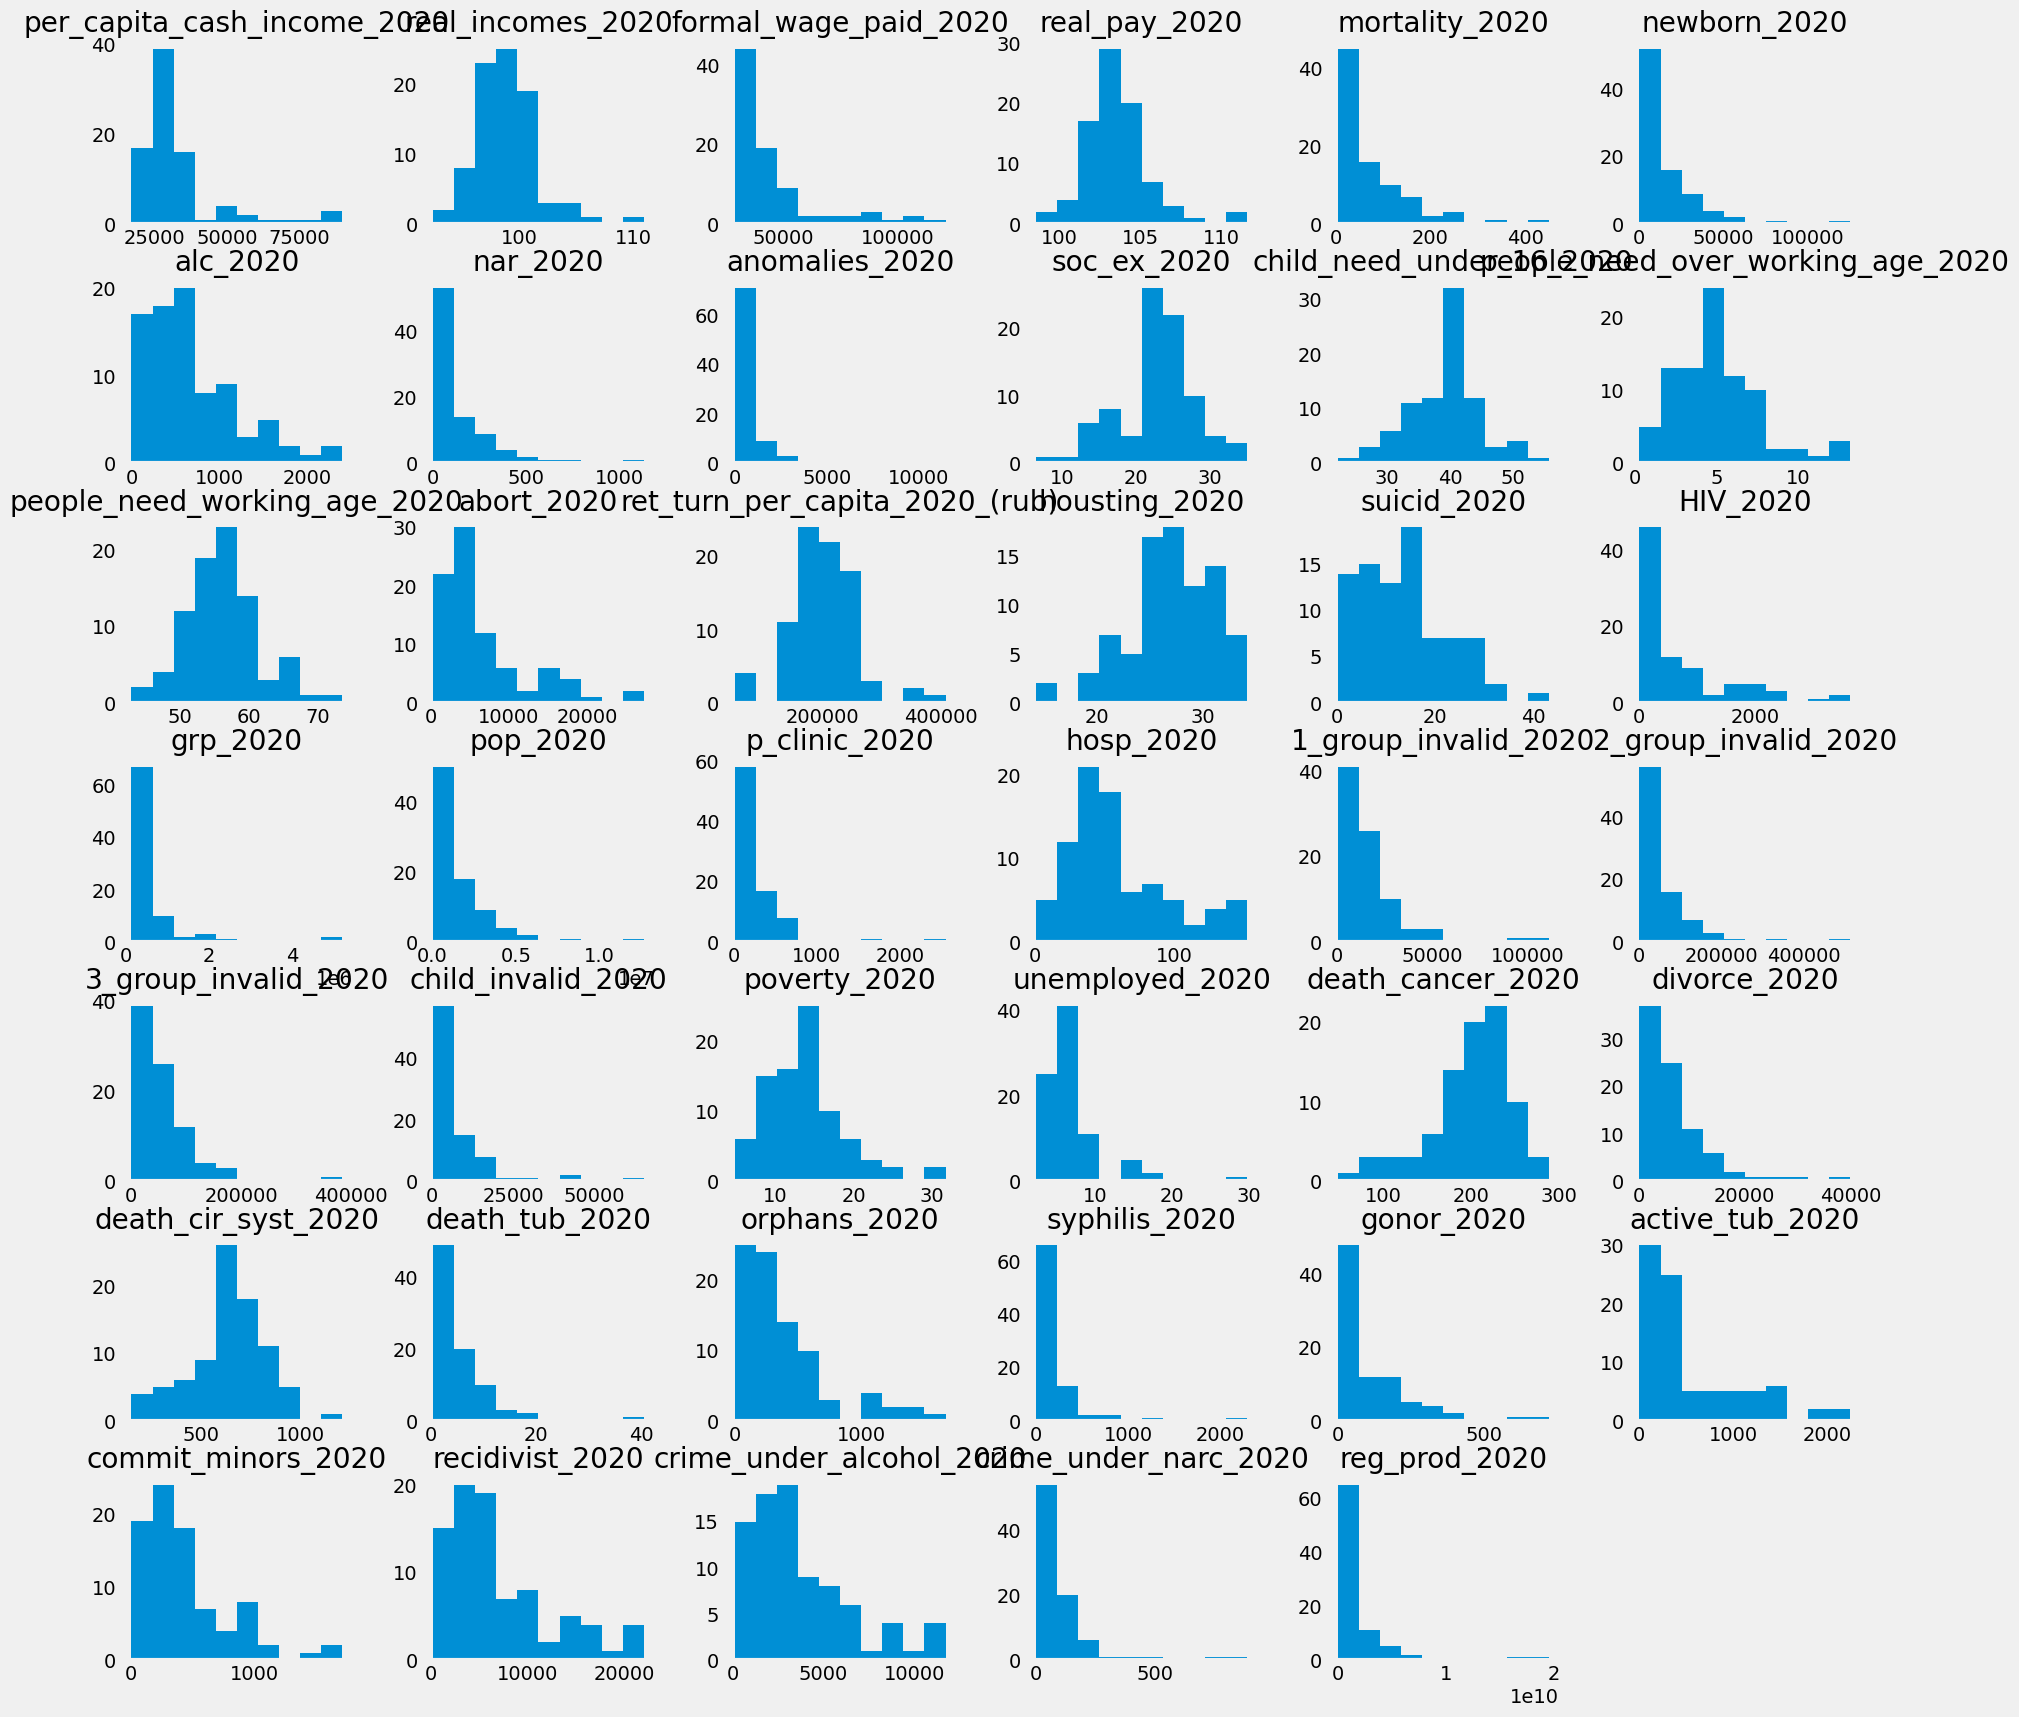

In [81]:
social_1.hist(figsize = (20,20), grid = False);
plt.show()

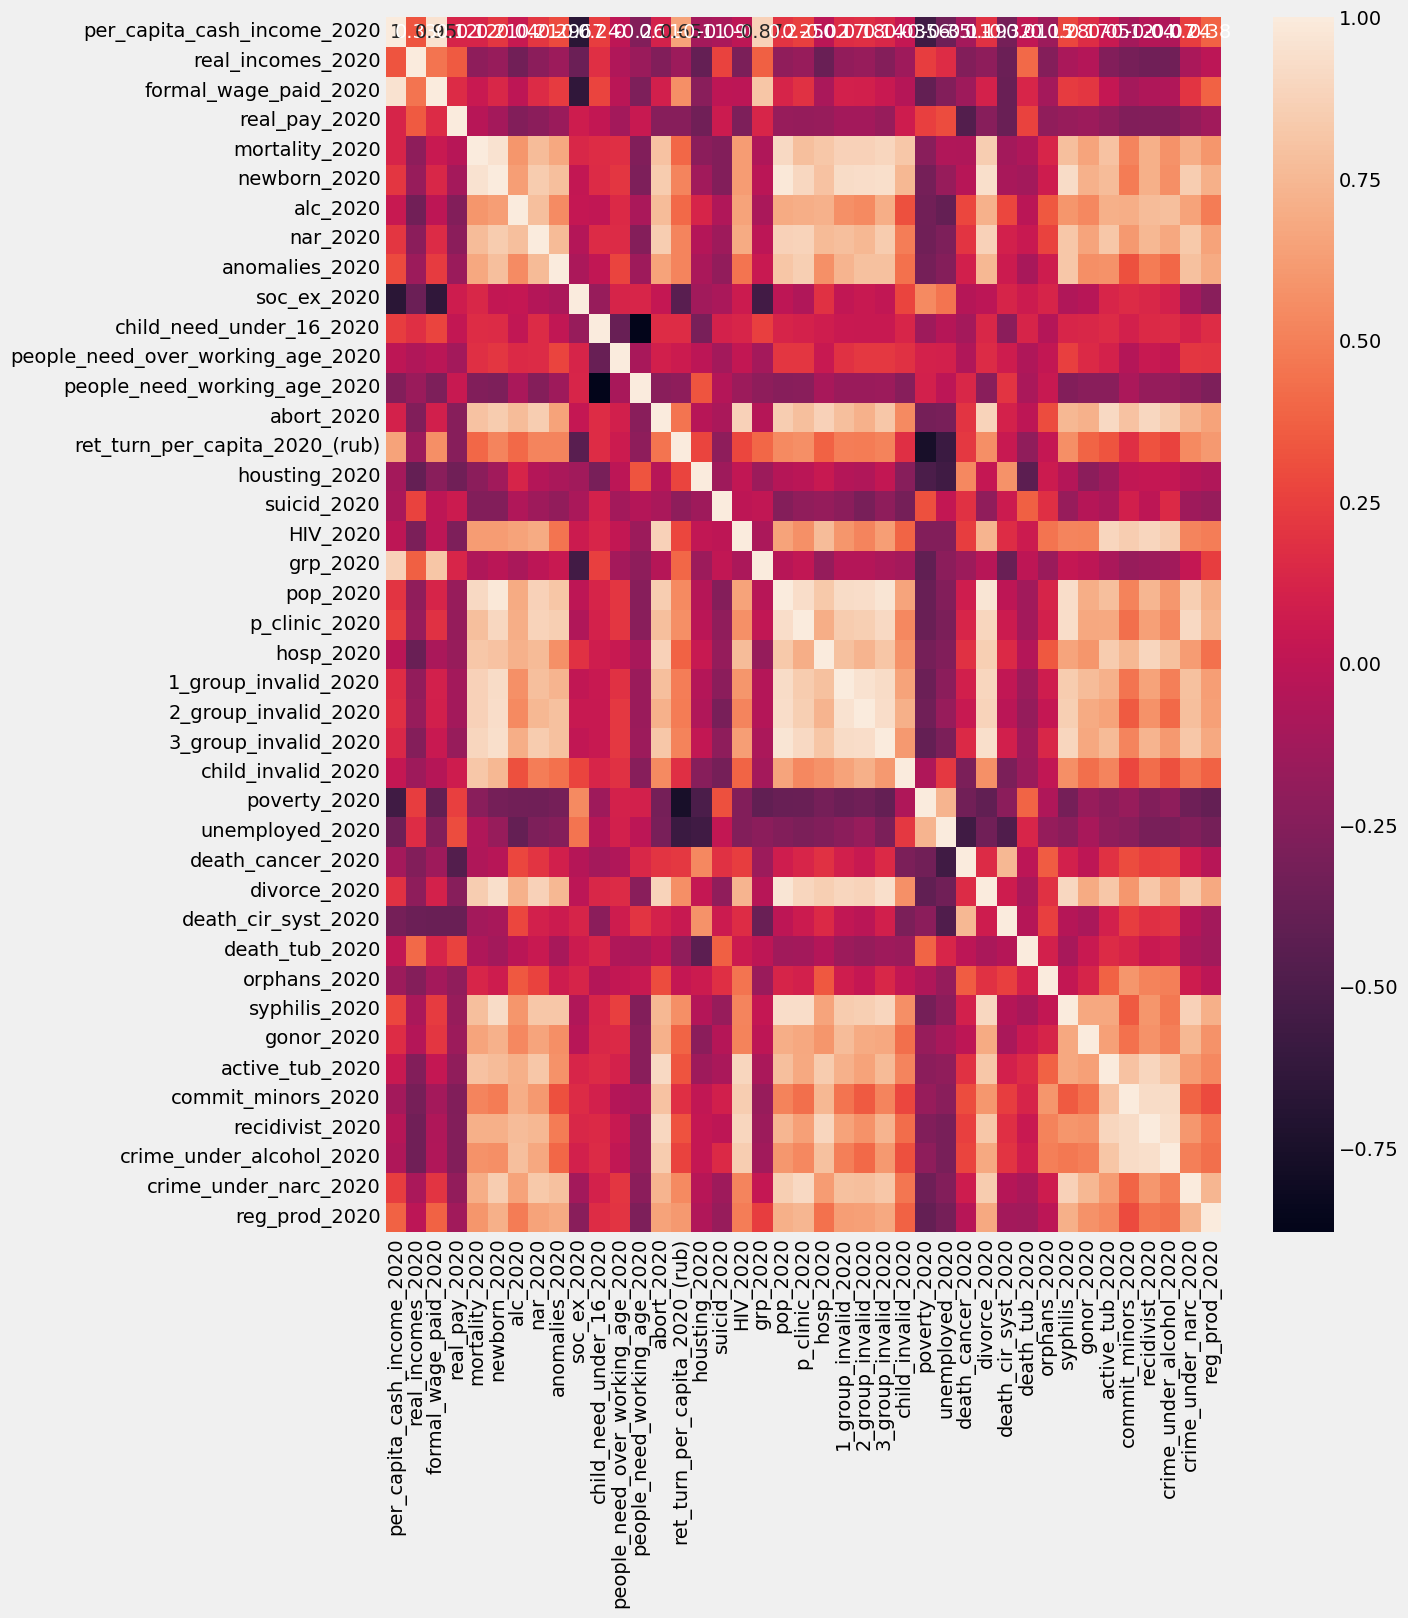

In [82]:
plt.figure(figsize=(12, 15))
sns.heatmap(social_1.corr().round(decimals=2), annot=True)
plt.show()

In [4]:
social_1.corr(numeric_only=True)

,per_capita_cash_income_2020,real_incomes_2020,formal_wage_paid_2020,real_pay_2020,mortality_2020,newborn_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,...,death_tub_2020,orphans_2020,syphilis_2020,gonor_2020,active_tub_2020,commit_minors_2020,recidivist_2020,crime_under_alcohol_2020,crime_under_narc_2020,reg_prod_2020
per_capita_cash_income_2020,1.000000,0.332670,0.945488,0.123029,0.115352,0.207097,0.038789,0.206979,0.287334,-0.666420,...,0.007832,-0.153019,0.279541,0.169441,0.050009,-0.119283,-0.043413,-0.069275,0.242340,0.383542
real_incomes_2020,0.332670,1.000000,0.446896,0.352159,-0.211379,-0.167121,-0.334753,-0.221875,-0.150419,-0.359537,...,0.413803,-0.253305,-0.088947,-0.048578,-0.264735,-0.311300,-0.342337,-0.337016,-0.093825,-0.008114
formal_wage_paid_2020,0.945488,0.446896,1.000000,0.160373,0.050974,0.135960,-0.000253,0.157147,0.227144,-0.642848,...,0.134331,-0.109482,0.226559,0.208715,0.028396,-0.108160,-0.071013,-0.062043,0.204629,0.378996
real_pay_2020,0.123029,0.352159,0.160373,1.000000,-0.026216,-0.106075,-0.262689,-0.224934,-0.156755,0.065192,...,0.256570,-0.204885,-0.165075,-0.153456,-0.198606,-0.271914,-0.262826,-0.264928,-0.192433,-0.129662
mortality_2020,0.115352,-0.211379,0.050974,-0.026216,1.000000,0.947695,0.588240,0.773089,0.670794,0.137633,...,-0.068667,0.131427,0.779026,0.662645,0.795763,0.522118,0.709503,0.575316,0.695798,0.588605
newborn_2020,0.207097,-0.167121,0.135960,-0.106075,0.947695,1.000000,0.634139,0.839024,0.778107,0.023393,...,-0.117971,0.073585,0.915961,0.723753,0.770998,0.478440,0.706866,0.563950,0.847550,0.705468
alc_2020,0.038789,-0.334753,-0.000253,-0.262689,0.588240,0.634139,1.000000,0.776160,0.551609,0.025568,...,-0.021217,0.340065,0.593604,0.527252,0.709135,0.695330,0.771362,0.784317,0.648371,0.484842
nar_2020,0.206979,-0.221875,0.157147,-0.224934,0.773089,0.839024,0.776160,1.000000,0.762719,-0.045806,...,0.048873,0.260541,0.821694,0.660265,0.820547,0.607162,0.753646,0.668036,0.829863,0.649013
anomalies_2020,0.287334,-0.150419,0.227144,-0.156755,0.670794,0.778107,0.551609,0.762719,1.000000,-0.076444,...,-0.098033,0.070951,0.820501,0.564360,0.578245,0.305416,0.480079,0.395179,0.794124,0.691911
soc_ex_2020,-0.666420,-0.359537,-0.642848,0.065192,0.137633,0.023393,0.025568,-0.045806,-0.076444,1.000000,...,0.055561,0.118897,-0.056616,-0.030357,0.127485,0.155047,0.138236,0.100810,-0.122079,-0.229287


* удаляем мультиколлинеарность из нашей таблицы

In [5]:
corr_matrix = social_1.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
social_1.drop(to_drop, axis=1, inplace=True)

<Axes: >

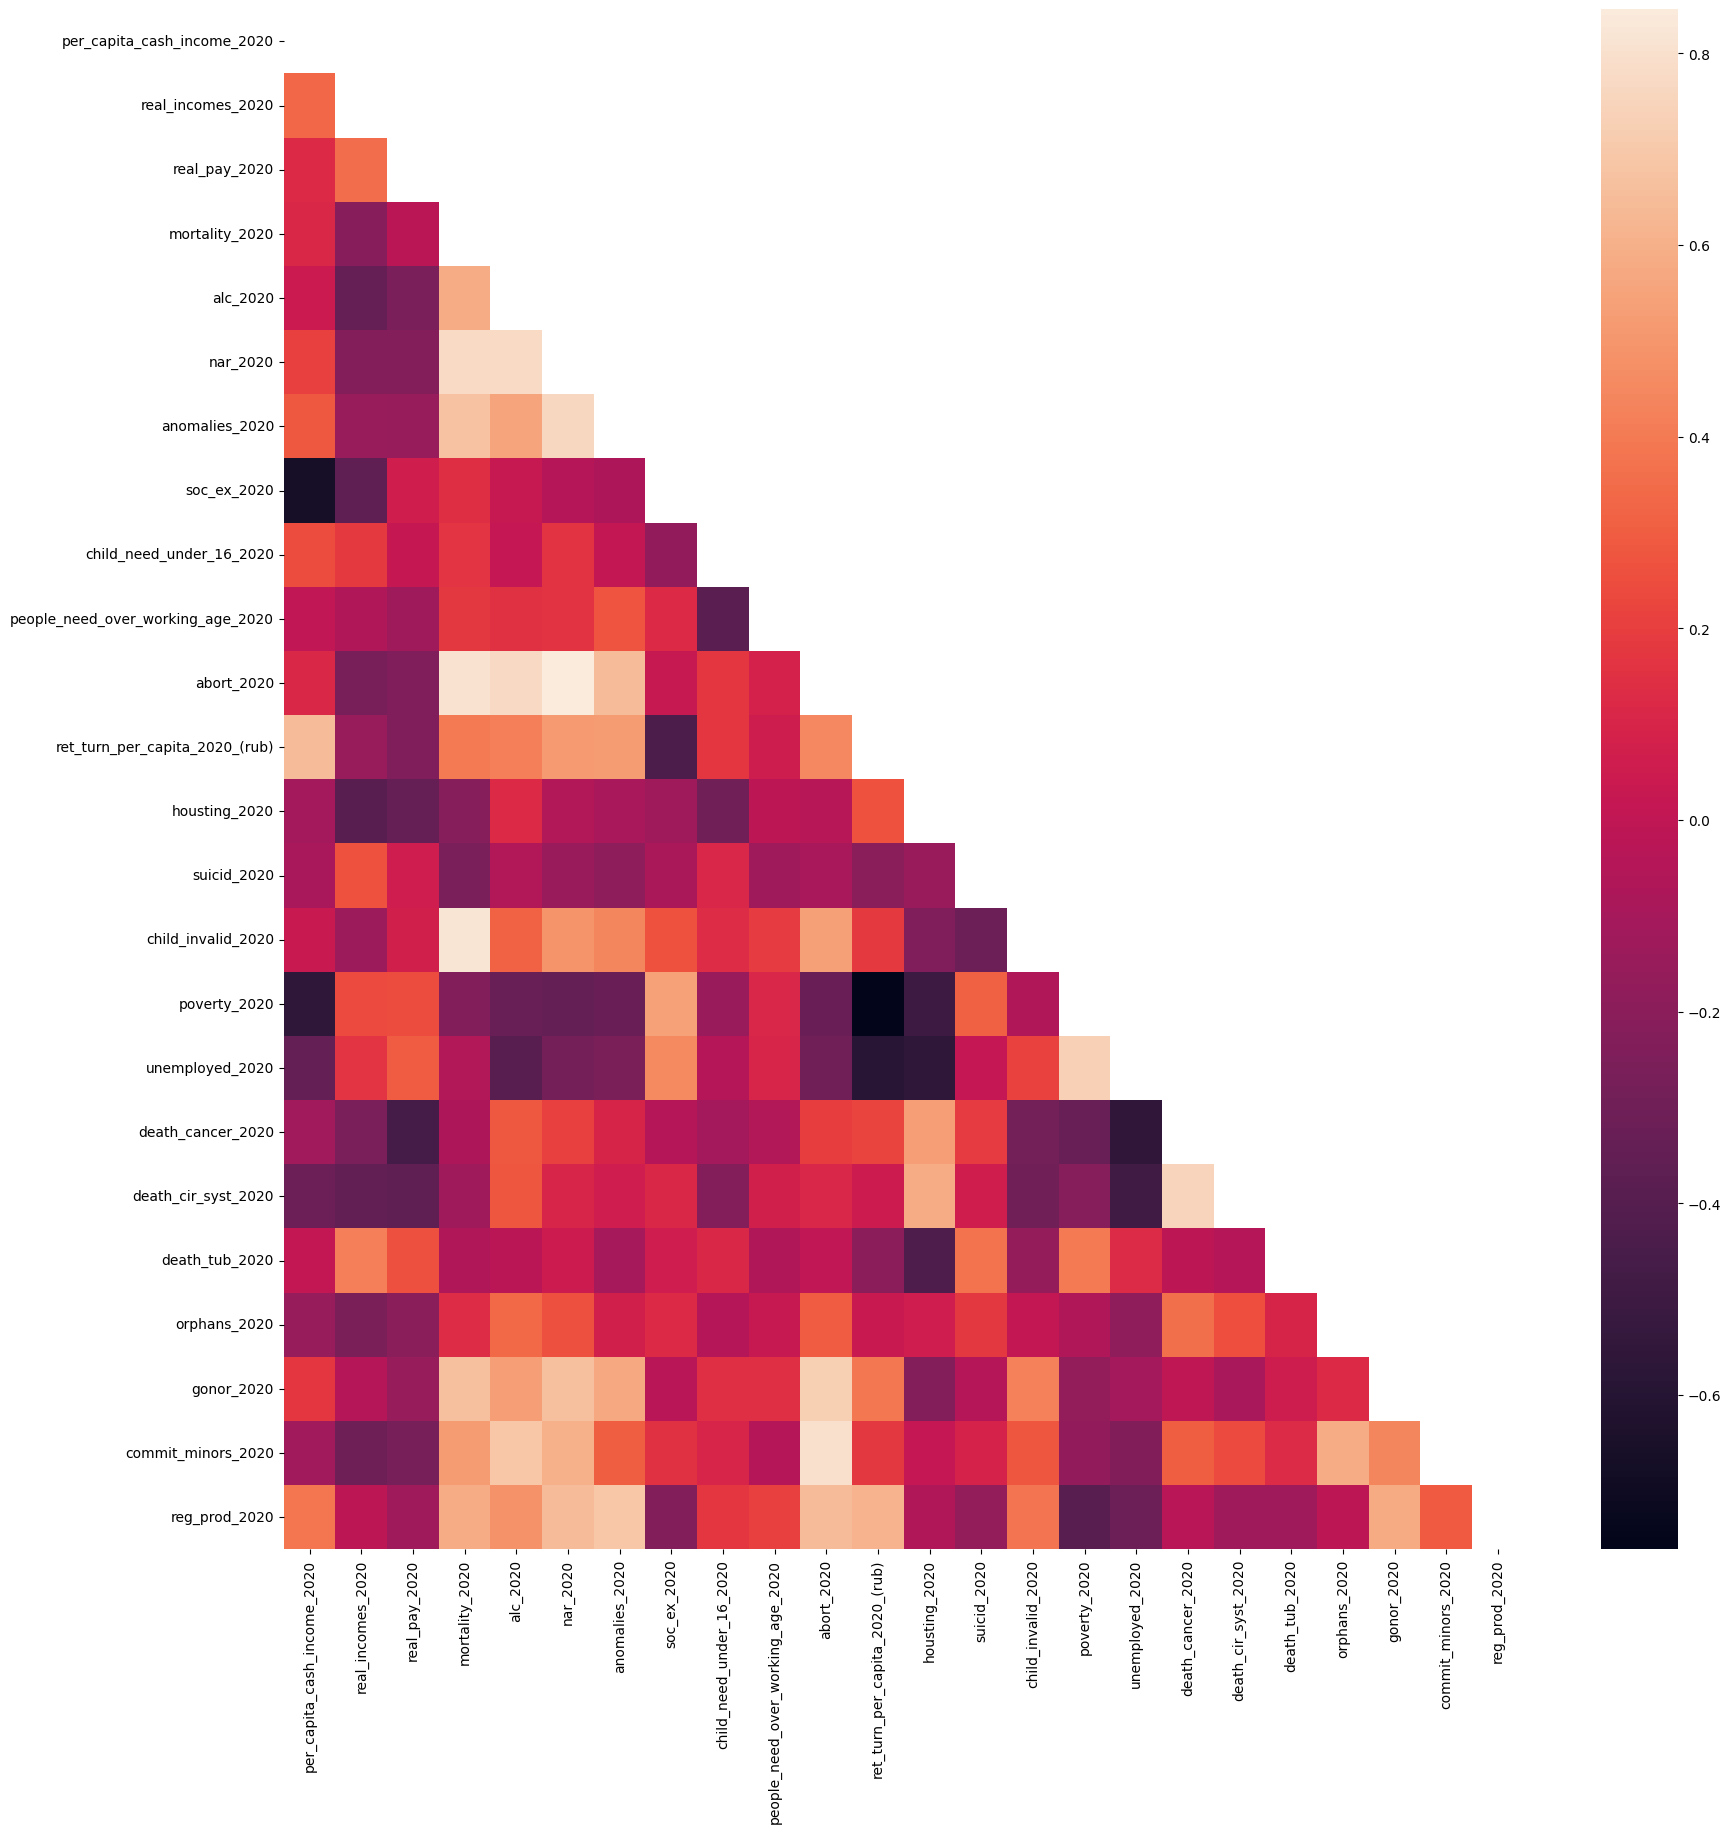

In [6]:
plt.figure(figsize=(20, 20))
matrix = np.triu(social_1.corr())
sns.heatmap(social_1.corr(), annot=True, mask=matrix)

In [7]:
s_scaler = preprocessing.StandardScaler()

scaled_df = s_scaler.fit_transform(social_1) 
scaled_df

array([[-0.6176612 , -1.23835681,  0.15889162, ..., -0.35050939,
         1.23631153, -0.32764665],
       [ 0.16718827,  0.48840183,  0.86179509, ...,  0.19310882,
        -0.03217022, -0.47922421],
       [ 0.1235443 , -0.1951068 , -0.29297489, ..., -0.27500686,
         0.30164077,  0.01136594],
       ...,
       [ 3.81264039,  2.25113462,  3.52278679, ..., -0.66006976,
        -1.18938163, -0.5277212 ],
       [ 3.83874583,  2.82672083,  2.26760202, ..., -0.637419  ,
        -1.01969438,  1.23331415],
       [-0.23653533, -0.26705507, -1.2971227 , ..., -0.55436622,
        -0.48281504, -0.2915571 ]])

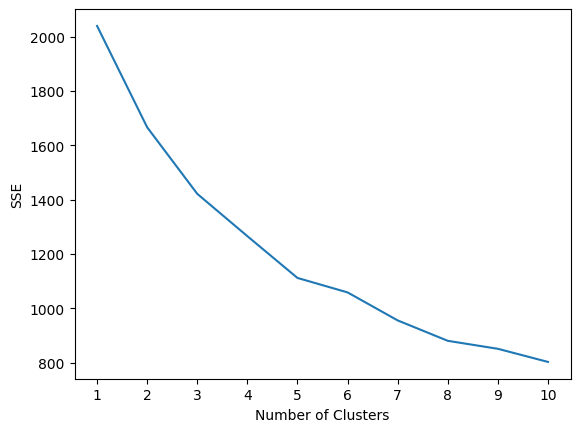

In [8]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [9]:
kl = KneeLocator(
   range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

5

In [89]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

for k in range(2,11):
    kmeans = KMeans(n_clusters = k,**kmeans_kwargs)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df,kmeans.labels_)
    silhouette_coefficients.append(score)

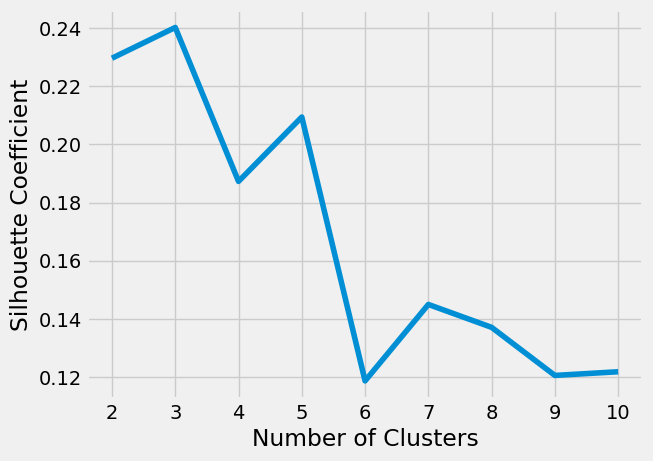

In [90]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

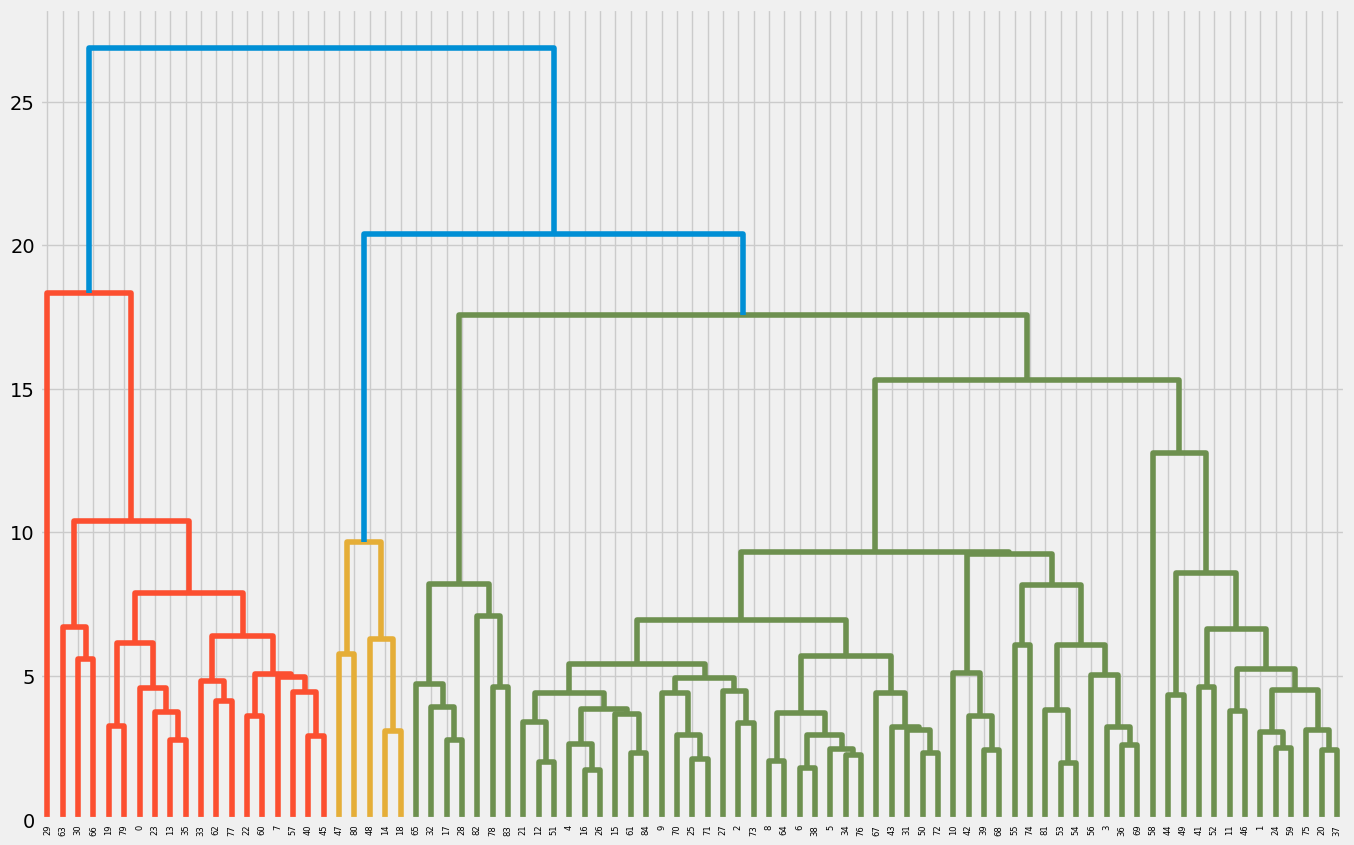

In [91]:
X1 = social_1

sc = StandardScaler()
X_sc = sc.fit_transform(X1)

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42) 
kmeans.fit(scaled_df)

y_kmeans = kmeans.predict(scaled_df)

social_1['cluster'] = pd.Series(y_kmeans, index=social_1.index)
social_1['cluster']

region
Алтайский край                       0
Амурская область                     1
Архангельская область без округов    1
Астраханская область                 1
Белгородская область                 1
                                    ..
Чеченская Республика                 3
Чувашская Республика                 1
Чукотский автономный округ           2
Ямало-Ненецкий автономный округ      2
Ярославская область                  1
Name: cluster, Length: 85, dtype: int32

In [11]:
social_1['cluster'].value_counts().sort_index()

cluster
0    20
1    47
2     9
3     8
4     1
Name: count, dtype: int64

In [12]:
social_1[social_1['cluster'] == 0].index

Index(['Алтайский край', 'Волгоградская область', 'Иркутская область',
       'Кемеровская область', 'Краснодарский край', 'Красноярский край',
       'Московская область', 'Нижегородская область', 'Новосибирская область',
       'Пермский край', 'Приморский край', 'Республика Башкортостан',
       'Республика Татарстан', 'Ростовская область', 'Самарская область',
       'Санкт-Петербург', 'Свердловская область',
       'Тюменская область без округов', 'Хабаровский край',
       'Челябинская область'],
      dtype='object', name='region')

In [13]:
social_1[social_1['cluster'] == 1].index

Index(['Амурская область', 'Архангельская область без округов',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Вологодская область', 'Воронежская область',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Калининградская область', 'Калужская область',
       'Кировская область', 'Костромская область', 'Курганская область',
       'Курская область', 'Ленинградская область', 'Липецкая область',
       'Новгородская область', 'Омская область', 'Оренбургская область',
       'Орловская область', 'Пензенская область', 'Псковская область',
       'Республика Адыгея', 'Республика Бурятия', 'Республика Карелия',
       'Республика Коми', 'Республика Крым', 'Республика Марий Эл',
       'Республика Мордовия', 'Республика Северная Осетия-Алания',
       'Республика Хакасия', 'Рязанская область', 'Саратовская область',
       'Севастополь', 'Смоленская область', 'Ставропольский край',
       'Там

In [14]:
social_1[social_1['cluster'] == 2].index

Index(['Камчатский край', 'Магаданская область', 'Мурманская область',
       'Ненецкий автономный округ', 'Республика Саха (Якутия)',
       'Сахалинская область', 'Ханты-Мансийский автономный округ - Югра',
       'Чукотский автономный округ', 'Ямало-Ненецкий автономный округ'],
      dtype='object', name='region')

In [15]:
social_1[social_1['cluster'] == 3].index

Index(['Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика',
       'Республика Алтай', 'Республика Дагестан', 'Республика Ингушетия',
       'Республика Калмыкия', 'Республика Тыва', 'Чеченская Республика'],
      dtype='object', name='region')

In [16]:
social_1[social_1['cluster'] == 4].index

Index(['Москва'], dtype='object', name='region')

* для облегчения технической возможности дальнейшей работы с кластерами, создаем отдельные датафреймы на каждый кластер

In [17]:
df_0= social_1.loc[social_1['cluster'] == 0]
df_0

,per_capita_cash_income_2020,real_incomes_2020,real_pay_2020,mortality_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,child_need_under_16_2020,people_need_over_working_age_2020,...,poverty_2020,unemployed_2020,death_cancer_2020,death_cir_syst_2020,death_tub_2020,orphans_2020,gonor_2020,commit_minors_2020,reg_prod_2020,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,95.5,103.8,97.0,1357,229,341.00,29.7,31.400000,9.200000,...,17.5,5.9,229.70,707.30,12.40,647,66,887,8.524434e+08,0
Волгоградская область,24864.0,98.7,104.2,97.0,2088,202,480.99,25.1,46.200000,4.000000,...,11.9,7.6,208.40,857.20,6.40,110,96,873,1.808537e+09,0
Иркутская область,27571.0,100.4,103.5,167.0,1504,308,357.00,28.6,41.500000,7.000000,...,17.6,7.7,224.90,673.80,11.10,300,266,1150,2.435841e+09,0
Кемеровская область,25433.0,98.1,100.6,129.0,860,318,258.00,23.0,39.700000,4.500000,...,13.2,6.7,246.00,802.50,9.90,1660,229,1507,3.031613e+09,0
Краснодарский край,36838.0,100.4,103.2,230.0,470,145,915.00,25.7,39.300000,6.900000,...,10.4,5.7,187.50,528.30,3.90,527,183,936,2.174704e+09,0
Красноярский край,32832.0,99.8,105.5,153.0,1407,396,677.00,24.8,35.800000,4.800000,...,17.0,6.0,235.50,662.59,9.19,1271,273,1006,5.142343e+09,0
Московская область,47046.0,97.8,101.8,246.0,2173,756,3169.00,19.4,49.900000,5.700000,...,6.8,3.6,172.00,502.40,1.70,271,352,767,7.046755e+09,0
Нижегородская область,33645.0,95.2,102.8,128.0,1178,247,5864.00,22.2,31.700000,3.800000,...,9.4,4.6,193.30,856.00,1.40,559,52,828,3.001558e+09,0
Новосибирская область,31563.0,99.8,102.9,164.0,1177,363,2278.00,25.4,34.100000,4.400000,...,13.8,6.7,244.30,776.40,11.70,423,192,1075,1.416021e+09,0


In [18]:
df_1=social_1.loc[social_1['cluster'] == 1]
df_1

,per_capita_cash_income_2020,real_incomes_2020,real_pay_2020,mortality_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,child_need_under_16_2020,people_need_over_working_age_2020,...,poverty_2020,unemployed_2020,death_cancer_2020,death_cir_syst_2020,death_tub_2020,orphans_2020,gonor_2020,commit_minors_2020,reg_prod_2020,cluster
region,,,,,,,,,,,,,,,,,,,,,
Амурская область,35499.0,100.3,105.2,42.0,530,128,53.00,21.7,38.400000,4.700000,...,15.2,6.0,232.20,641.79,12.00,567,138,431,4.045765e+08,1
Архангельская область без округов,34852.0,98.4,102.9,29.0,665,64,449.00,21.4,28.500000,7.200000,...,12.3,7.3,241.20,793.09,1.80,1034,76,551,1.854125e+09,1
Астраханская область,25199.0,97.1,104.5,64.0,75,1,212.00,31.4,42.100000,5.500000,...,15.6,7.9,189.20,641.49,11.20,579,107,343,7.245978e+08,1
Белгородская область,32841.0,98.1,104.8,47.0,612,48,498.00,16.1,39.016438,5.045205,...,7.2,4.9,179.90,669.60,0.40,413,18,219,1.948294e+09,1
Брянская область,28596.0,96.3,102.9,41.0,646,94,360.00,23.1,44.800000,3.700000,...,13.6,4.0,265.10,725.70,3.30,179,16,197,5.669245e+08,1
Владимирская область,25922.0,98.0,103.0,61.0,822,85,136.00,26.0,39.016438,5.045205,...,12.5,5.6,247.10,931.70,2.20,246,47,378,1.162652e+09,1
Вологодская область,29522.0,99.6,105.4,59.0,441,72,89.00,25.9,43.100000,2.300000,...,12.8,6.1,224.00,808.90,1.60,449,127,510,1.554870e+09,1
Воронежская область,32078.0,95.4,103.2,70.0,1601,324,35.00,21.6,28.500000,2.300000,...,8.5,4.3,179.80,677.60,1.60,54,57,481,1.436533e+09,1
Еврейская автономная область,28048.0,99.2,103.7,11.0,126,35,304.00,31.2,34.800000,10.800000,...,23.6,6.3,187.40,911.00,17.80,213,29,66,5.593881e+07,1


In [19]:
df_2=social_1.loc[social_1['cluster'] == 2]
df_2

,per_capita_cash_income_2020,real_incomes_2020,real_pay_2020,mortality_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,child_need_under_16_2020,people_need_over_working_age_2020,...,poverty_2020,unemployed_2020,death_cancer_2020,death_cir_syst_2020,death_tub_2020,orphans_2020,gonor_2020,commit_minors_2020,reg_prod_2020,cluster
region,,,,,,,,,,,,,,,,,,,,,
Камчатский край,55373.0,102.1,103.8,14.0,152,26,89.0,13.3,42.600000,5.900000,...,14.6,3.8,157.8,609.60,5.80,312,25,160,3.576285e+08,2
Магаданская область,70864.0,104.3,105.0,4.0,94,10,0.0,11.1,39.016438,5.045205,...,8.7,5.6,201.3,544.40,3.60,167,11,59,5.355506e+08,2
Мурманская область,46355.0,100.4,105.1,25.0,220,37,754.0,22.8,43.700000,0.400000,...,10.1,7.7,200.6,649.79,2.60,97,9,263,2.018215e+09,2
Ненецкий автономный округ,84147.0,101.1,101.4,4.0,78,2,0.0,14.4,39.016438,5.045205,...,9.4,8.8,212.4,359.29,2.29,77,0,20,5.259113e+08,2
Республика Саха (Якутия),46338.0,99.5,101.8,67.0,1035,40,98.0,16.8,44.200000,5.100000,...,17.3,7.4,131.6,404.90,2.29,235,428,335,1.874402e+09,2
Сахалинская область,60770.0,98.6,101.7,25.0,526,65,78.0,16.5,39.016438,5.045205,...,7.7,5.5,237.6,333.90,9.90,361,27,250,1.643729e+09,2
Ханты-Мансийский автономный округ - Югра,54443.0,100.4,103.5,75.0,389,65,83.0,15.8,55.600000,1.600000,...,8.4,3.0,122.5,264.70,2.29,18,91,328,6.932950e+09,2
Чукотский автономный округ,89541.0,105.2,110.5,8.0,137,0,0.0,6.4,39.016438,5.045205,...,8.0,4.4,118.2,424.80,20.00,63,25,15,2.612822e+08,2
Ямало-Ненецкий автономный округ,89928.0,106.8,108.0,25.0,286,51,170.0,12.6,51.000000,0.700000,...,4.8,2.4,93.8,214.80,4.59,65,28,76,5.464621e+09,2


In [20]:
df_3=social_1.loc[social_1['cluster'] == 3]
df_3

,per_capita_cash_income_2020,real_incomes_2020,real_pay_2020,mortality_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,child_need_under_16_2020,people_need_over_working_age_2020,...,poverty_2020,unemployed_2020,death_cancer_2020,death_cir_syst_2020,death_tub_2020,orphans_2020,gonor_2020,commit_minors_2020,reg_prod_2020,cluster
region,,,,,,,,,,,,,,,,,,,,,
Кабардино-Балкарская Республика,21957.0,98.7,105.0,57.0,257,84,0.0,34.4,35.9,6.7,...,24.2,14.8,128.9,440.5,6.2,177,51,134,1.002105e+08,3
Карачаево-Черкесская Республика,18949.0,97.3,107.0,25.0,54,13,0.0,26.5,27.6,6.9,...,23.2,14.7,102.9,352.4,0.6,124,45,86,8.113874e+07,3
Республика Алтай,21677.0,104.5,105.5,22.0,83,24,0.0,19.8,44.5,2.9,...,23.8,14.0,155.1,414.8,6.8,211,49,125,1.742333e+07,3
Республика Дагестан,27661.0,97.2,111.6,317.0,182,114,30.0,28.3,38.3,5.0,...,14.8,15.7,82.1,244.4,1.4,217,165,212,1.351843e+08,3
Республика Ингушетия,16877.0,99.7,104.3,47.0,0,13,0.0,32.5,38.1,10.6,...,30.0,29.8,48.3,148.4,1.2,0,36,26,8.555011e+06,3
Республика Калмыкия,19811.0,102.4,107.6,8.0,72,0,0.0,24.3,33.8,0.3,...,22.7,9.6,176.3,434.6,6.7,24,2,69,1.133862e+07,3
Республика Тыва,18972.0,110.9,107.0,36.0,154,29,0.0,23.8,45.0,2.6,...,31.7,18.0,113.7,332.6,40.4,18,175,258,4.658367e+07,3
Чеченская Республика,24596.0,100.1,104.0,181.0,61,35,0.0,35.1,43.7,6.2,...,20.4,18.5,76.3,191.9,0.8,0,0,6,8.698532e+07,3


In [21]:
df_4=social_1.loc[social_1['cluster'] == 4]
df_4

,per_capita_cash_income_2020,real_incomes_2020,real_pay_2020,mortality_2020,alc_2020,nar_2020,anomalies_2020,soc_ex_2020,child_need_under_16_2020,people_need_over_working_age_2020,...,poverty_2020,unemployed_2020,death_cancer_2020,death_cir_syst_2020,death_tub_2020,orphans_2020,gonor_2020,commit_minors_2020,reg_prod_2020,cluster
region,,,,,,,,,,,,,,,,,,,,,
Москва,77283.0,100.2,103.1,450.0,2397,1130,11435.0,17.5,38.4,13.2,...,6.0,2.6,214.1,516.7,1.5,0,646,480,1.956241e+10,4


* построим тепловые карты для анализа корреляции признаков по каждому кластеру. Внутри кластеров мультиколлинеарные признаки не будут удаляться, чтобы акцентировать внимание на очень сильную зависимость признаков друг на друга

<Axes: >

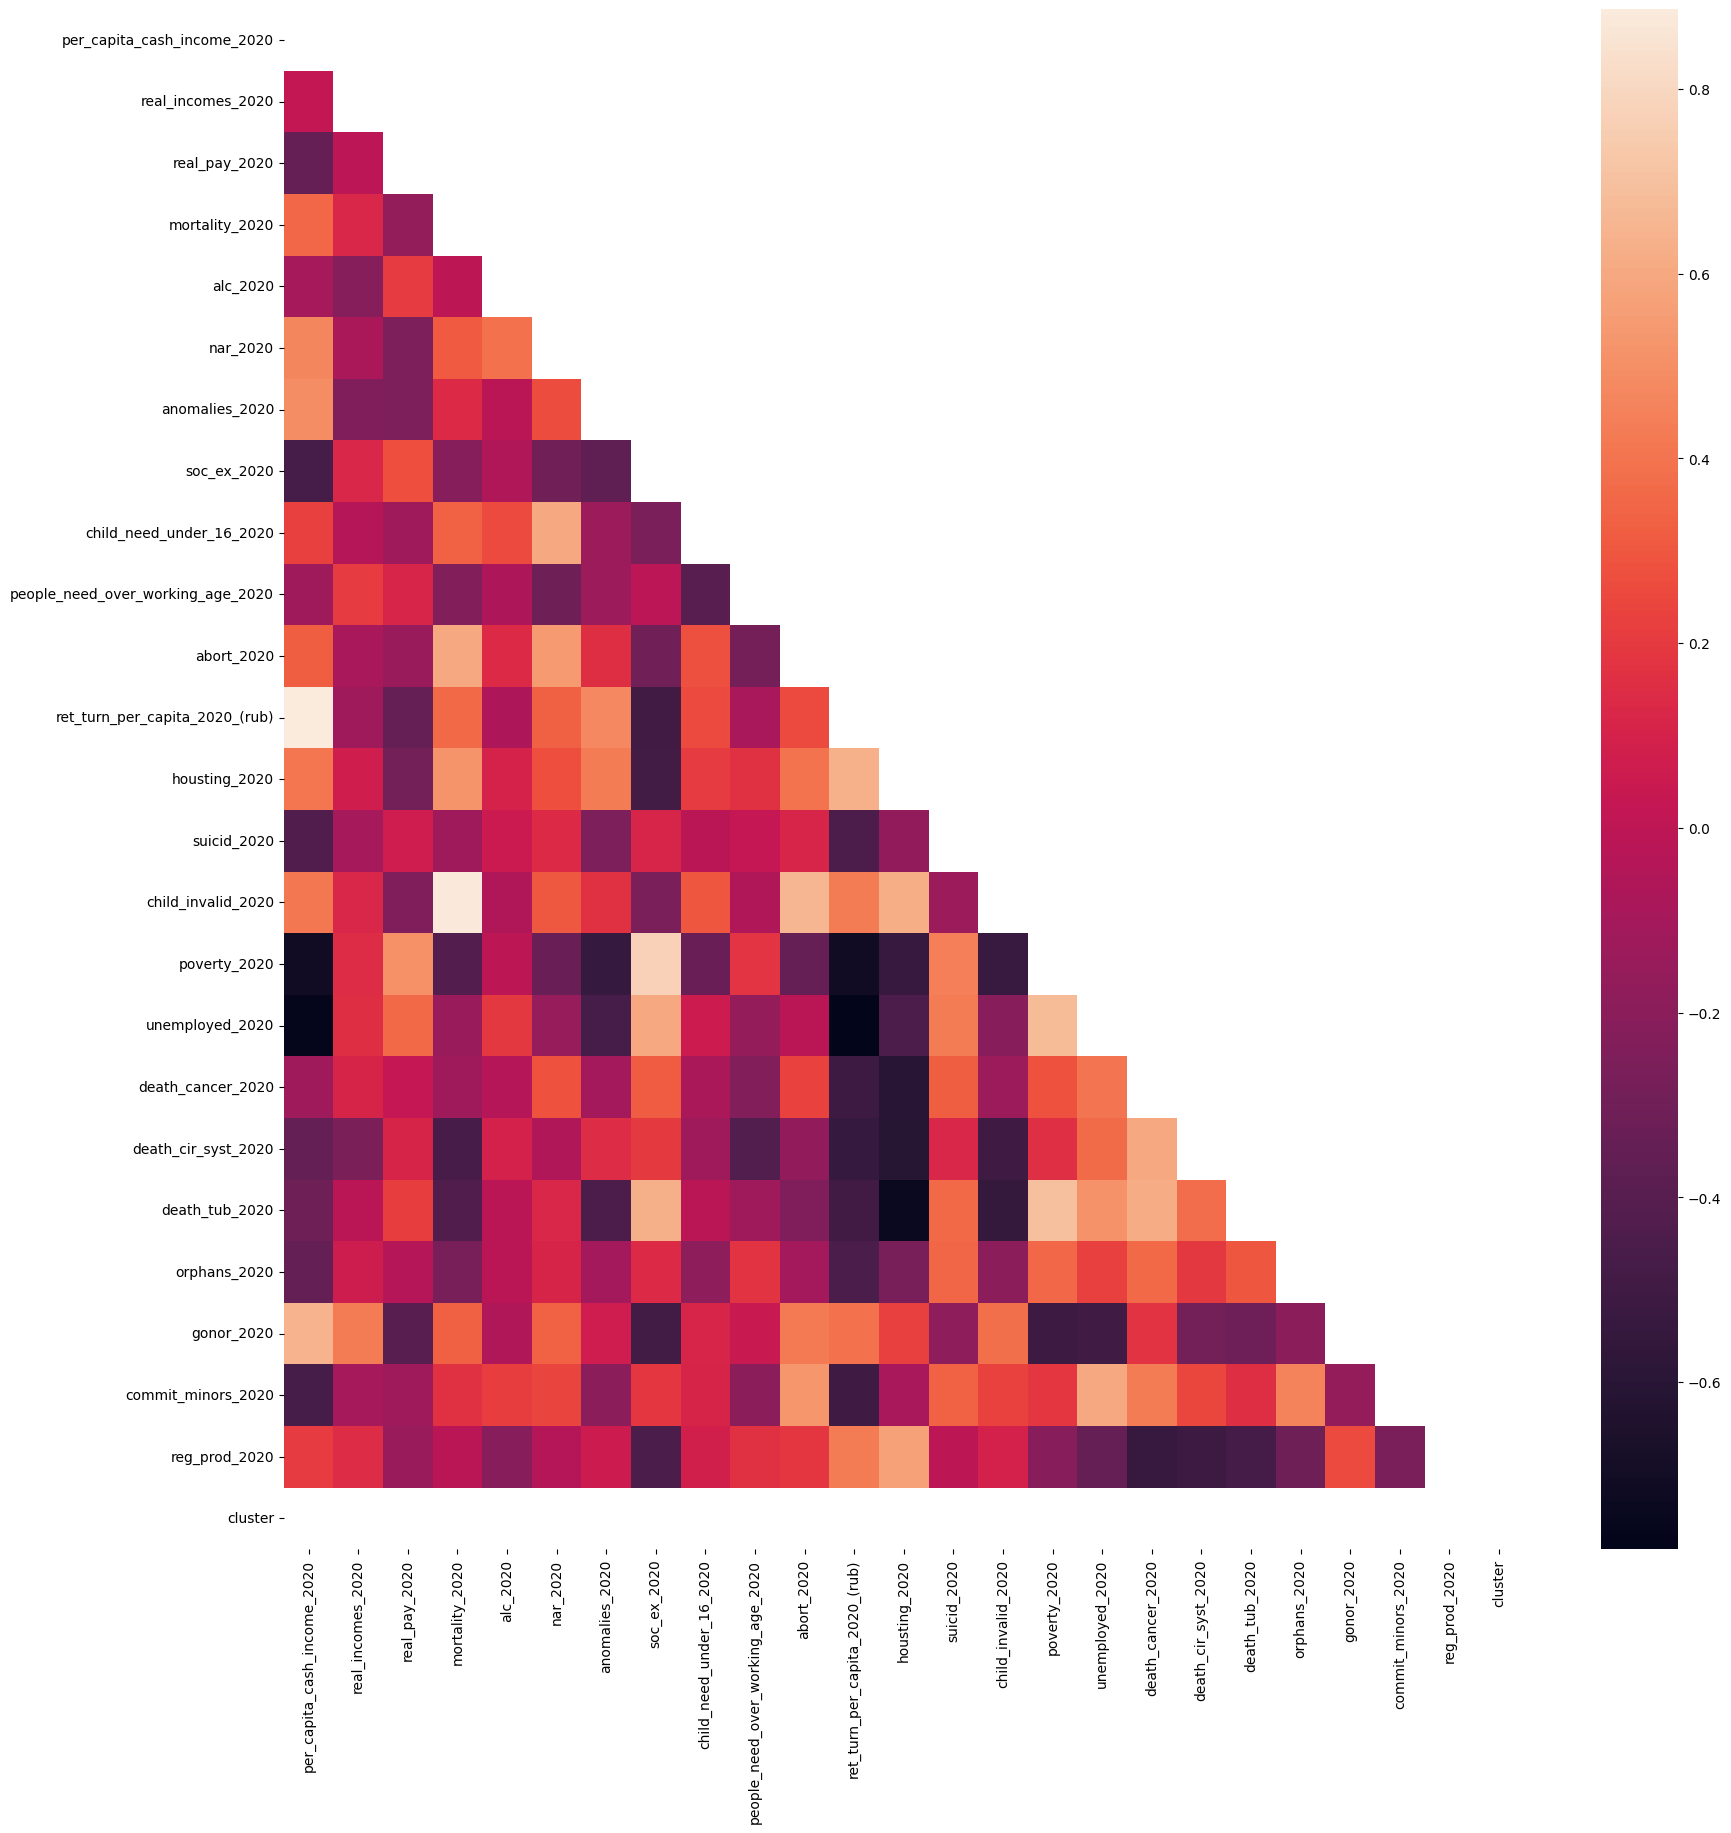

In [22]:
plt.figure(figsize=(20, 20))
matrix = np.triu(df_0.corr())
sns.heatmap(df_0.corr(), annot=True, mask=matrix)

В нулевой кластер попали регионы с достатком выше среднего. 
Проблемы, на которые стоит обратить Заказчику  внимание: 

* Достаточные доходы работающих жителей не повышают качество жизни, в частности,наблюдается "увлечение" наркотическими средствами, что, в свою очередь, приводит к рождению детей с аномалиями, при этом абортов меньше случаев аномалий, что может говорить о готовности родителей воспитывать таких детей.Эта теория подтверждается количеством детей-инвалидов.
* Так же высокий уровень заболевания гонореей, что, наверно, свойственно активной жизни молодых россиян этих регионов. Как мы видим, эти признаки взаимосвязаны друг с другом. Гонорея стала давно болезнью и богатого слоя населения: достаток в средствах, доступность качественной медпомощи приводит к понижению бдительности в связях с противоположным полом. Одновременно с этим наличие диагноза "гонорея" имеет продолжение: повышает риск абортов и рождения детей-инвалидов.
* Соцподдержка недостаточна для семей с детьми с врожденными аномалиями, детей до 16 лет и пенсионеров.
* Бедные и безработные обеспечены соцподдержкой, при этом последние так и остаются за чертой бедности (видимо сказывается низкий уровень пособия).
* Сироты  получают минимально необходимый уровень денежного обеспечения, что явлется недостаточным для нормальной жизни, т.к.  наблюдается высокий уровень жизни за чертой бедности, заболеваемости онкологией, туберкулезом.
* Риск возникновения онкологии в принципе не требует дополнительных факторов для возникновения, однако наблюдается зависимость с безработицей и бедностью. Следовательно,  мы наблюдаем те виды рака, которые вызваны ухудшением качества жизни, в частности, питания суррогатами.Это подтверждается и взаимосвязью с заболеваемостью сердечно-сосудистой системы, чья взамосвязь с качеством питания давно подтверждена наукой.
* Смертность от туберкулеза, всегда была зависима от бедности. Условия жизни, отсутствие надлежащей медпомощи повышает риск смерти от туберкулеза у бедных и заключенных.
* НКО стоит обратить внимание на необходимость социализации и соцподдержке подростков-преступников: одновременно и причиной, и следствием совершения предступлений является наличие статуса сироты/безработного. 

<Axes: >

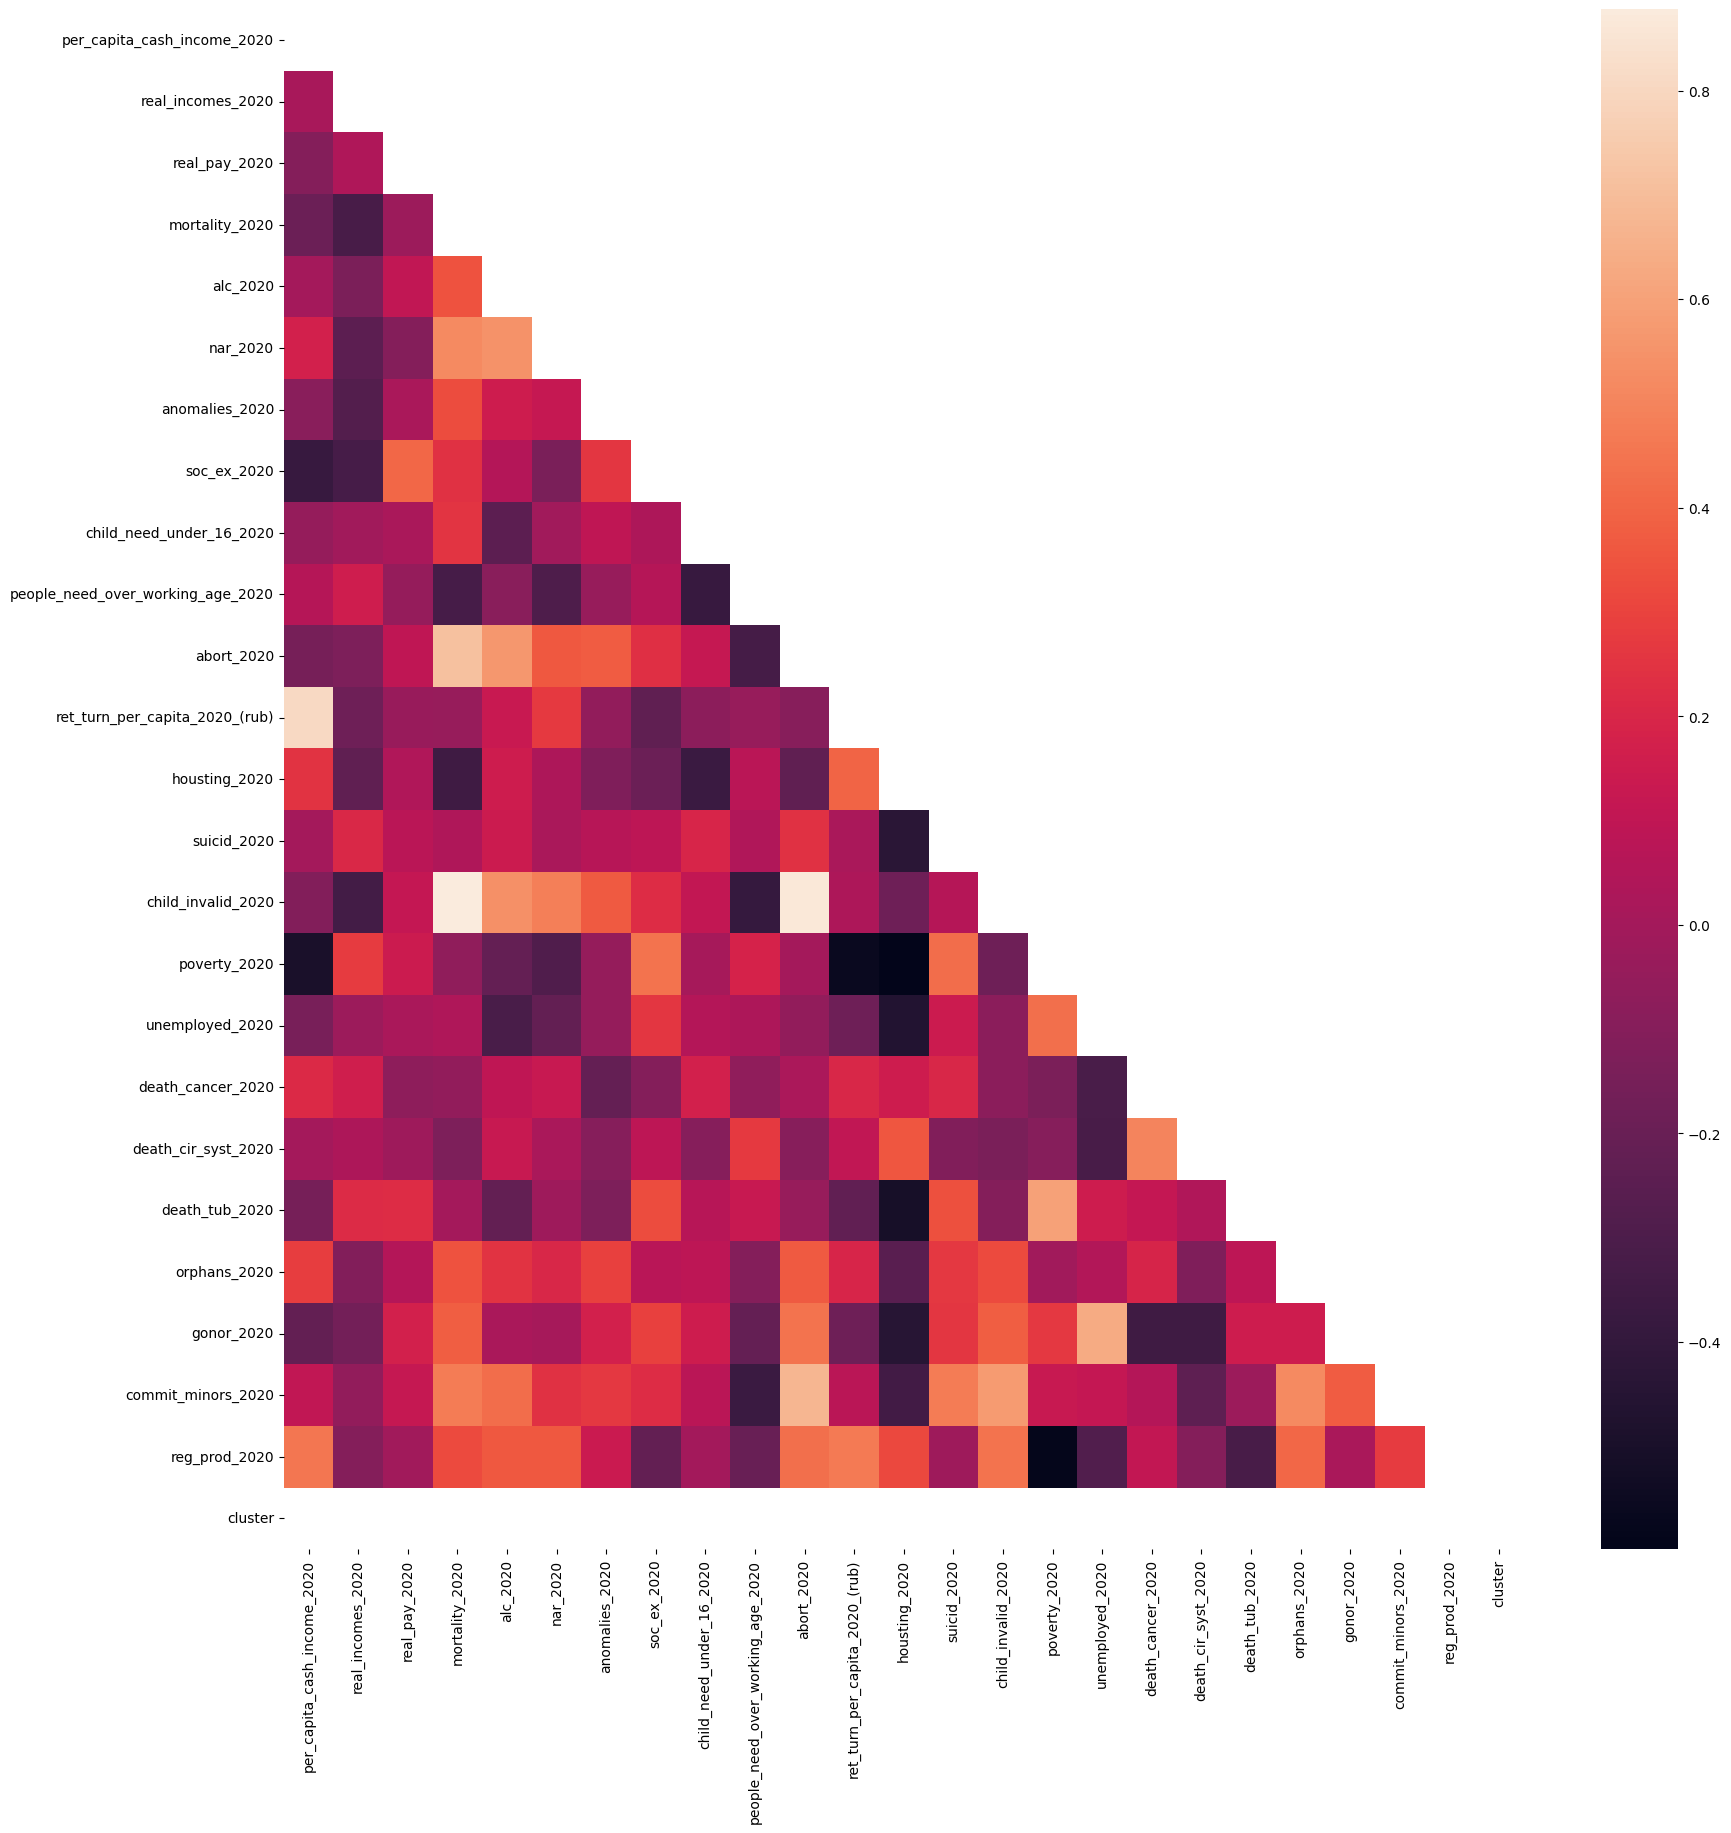

In [23]:
plt.figure(figsize=(20, 20))
matrix = np.triu(df_1.corr())
sns.heatmap(df_1.corr(), annot=True, mask=matrix)

В первый кластер попали регионы, представляющие саму Россию, т.е. ее основное население, по уровню жизни которой мы и можем судить о всей стране. 
Проблемы, на которые стоит обратить Заказчику  внимание: 
* Наркомания сочетается с алкоголизмом, что приводит к рождаемости слабых детей, т.е. избыточной смертности или абортам.
* Гонорея приводит к абортам или рождению детей-инвалидов, но в данном кластере гонорея- классически болезнь бедноты (корреляция с безработицей).
* Следует обратить внимание на детей-инвалидов, т.к. их наличие является последствием злоупотреблений алкоголем, наркотическими средствами.
* Безработные находятся за чертой бедности, что повышает риск суицида. Один из вариантов решения проблемы -повышение размера пособия по безработице.
* Как и в предыдущем кластере, онкология сочетается с заболеваемостью с/с системы. 
* В этом кластере, как и с гонореей, у смертности от туберкулеза наблюдается прямая корреляция с  бедностью.
* Сироты в большей степени имеют категорию инвалидности, такое же положение и у подростков-преступников.Такое положение требует повышенного внимания данным категориям граждан.

<Axes: >

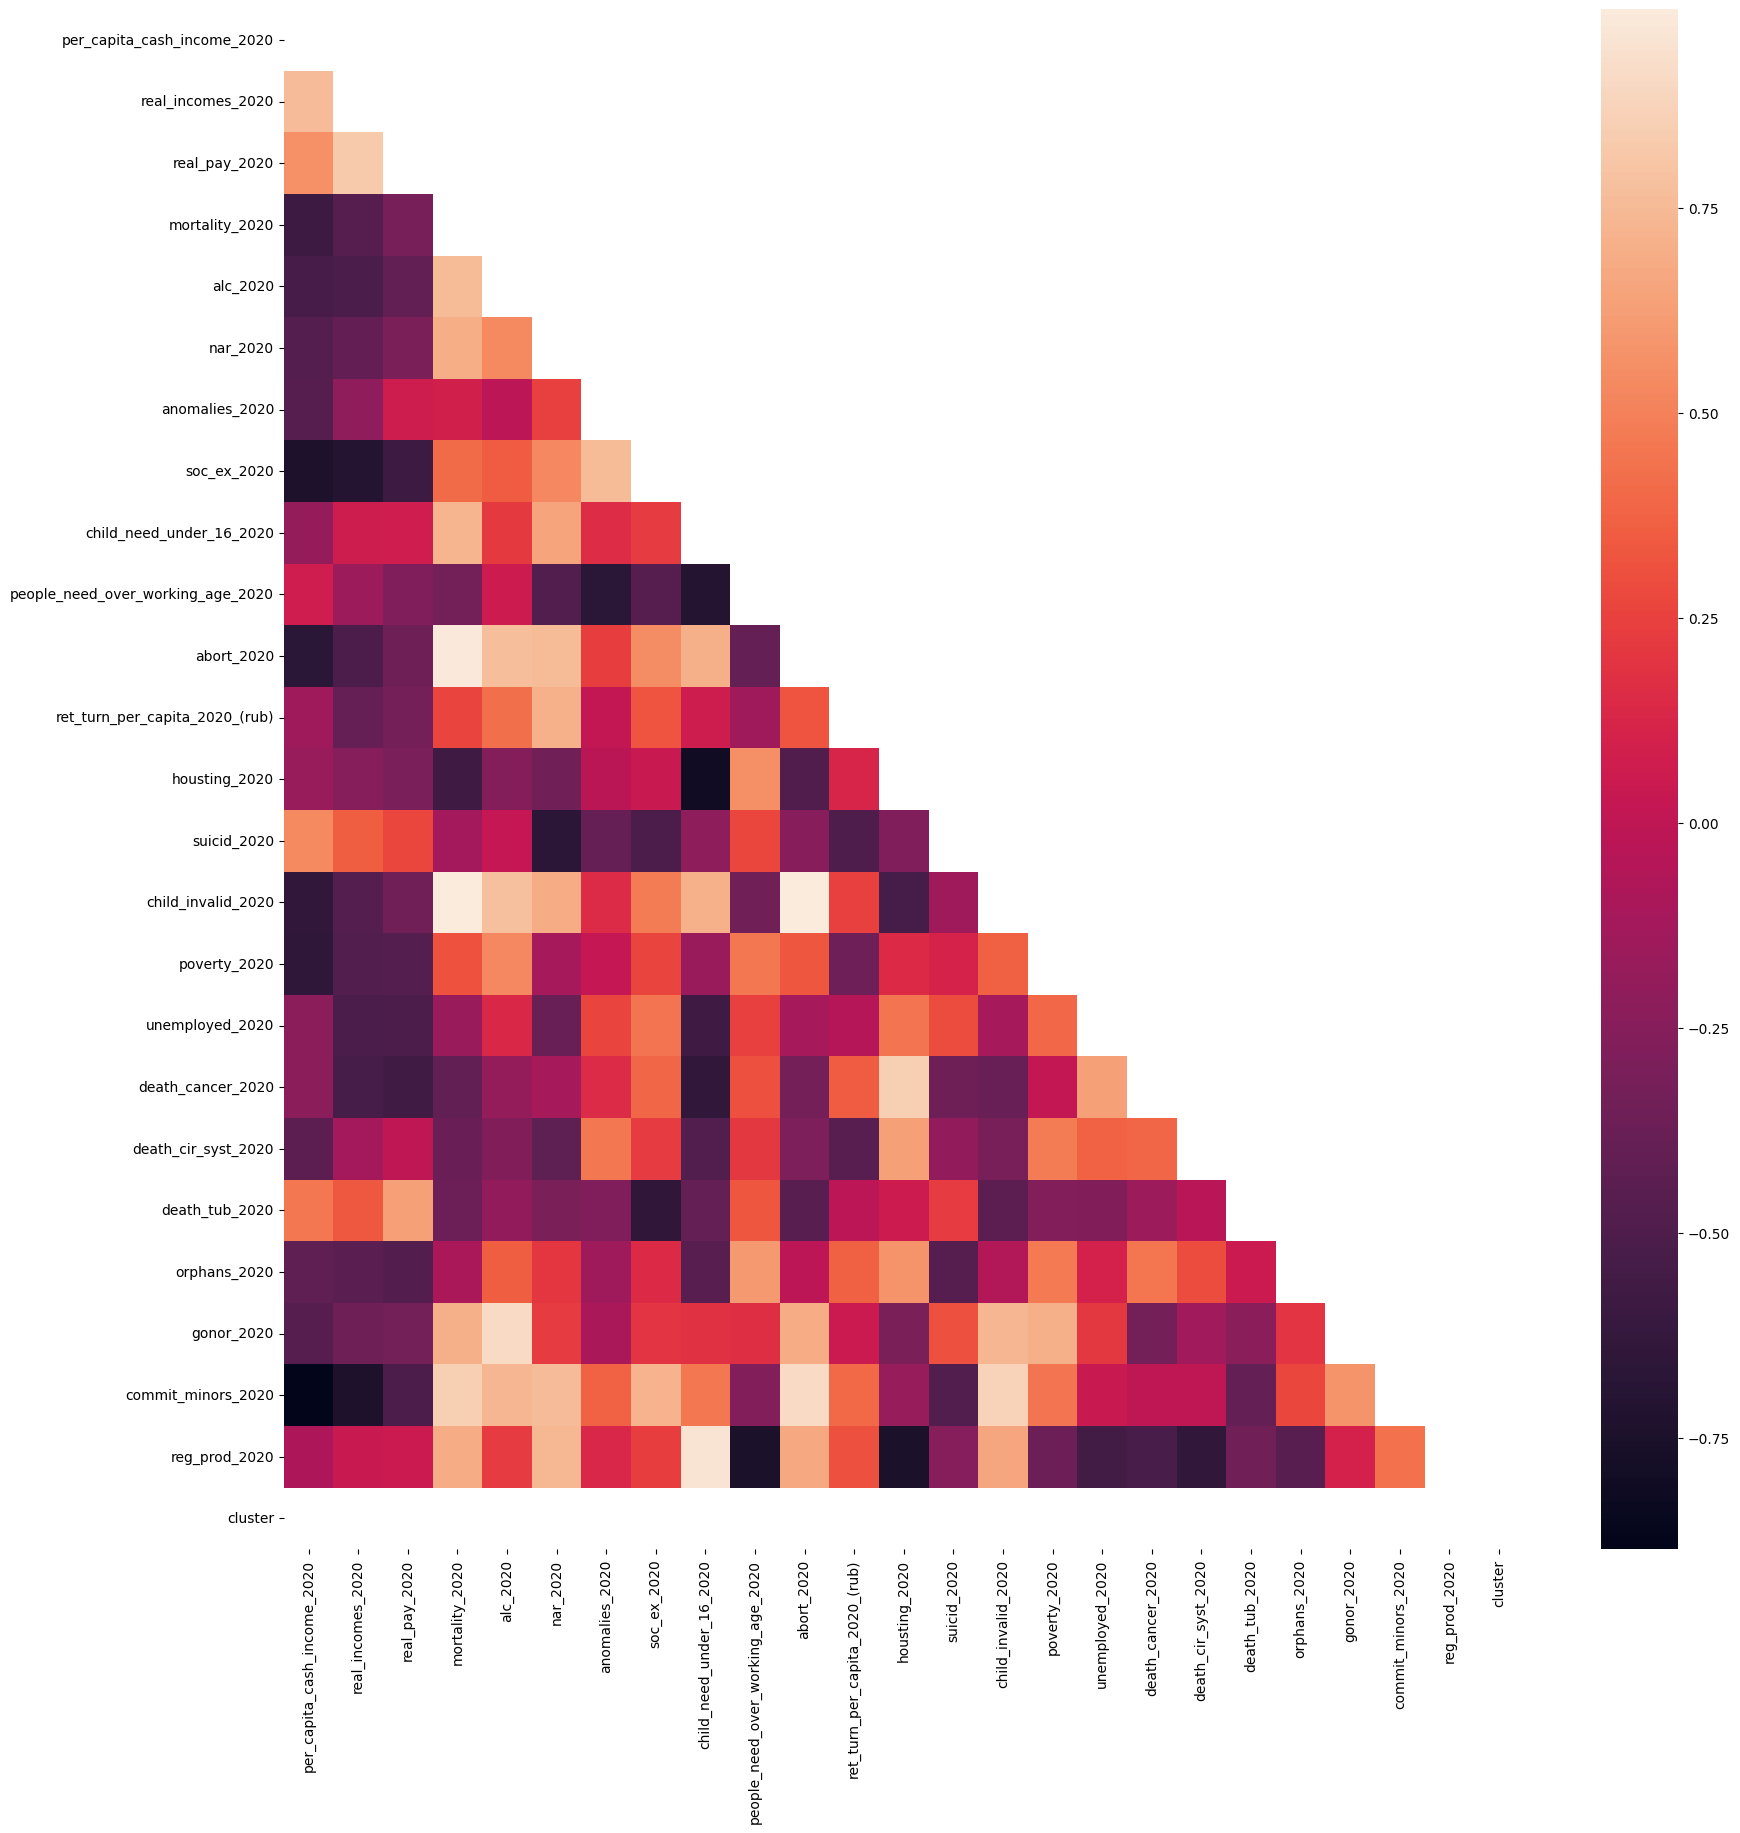

In [24]:
plt.figure(figsize=(20, 20))
matrix = np.triu(df_2.corr())
sns.heatmap(df_2.corr(), annot=True, mask=matrix)

Во второй кластер попали так называемые "северные" регионы.
Проблемы, на которые стоит обратить Заказчику  внимание: 
* "Увлечение" алкоголем и наркотическими средствами высокое, что приводит к избыточной смертности среди новорожденных.При этом рождение детей с аномалиями не высокое: только у наркоманов.Видимо снижено за счет абортов у больных алкоголизмом. Однако результатом является рождаемость детей-инвалидов. Особое внимание стоит обратить на увлечение наркотическими средствами именно детьми до 16 лет, которые попадают в итоге в нуждающуюся группу. Также немал уровень абортов, что указывает на отсуствие или недостаточность проводимой политики поддержания детства.
* За чертой бедности находятся дети-инвалиды и больные алкоголизмом(требуется проведение политики трудоустройства и социализации, чтобы разорвать замкнутый круг, в котором эти факторы сначала мешают работать, а потом и устроиться на работу).
* Гонорея  в данном кластере также представлена в классическом варианте.Наличие болезни приводит к рождаемости неспособных к жизни детей или детей-инвалидов, сочетается с алкоголизмом, наркоманией, абортами.

<Axes: >

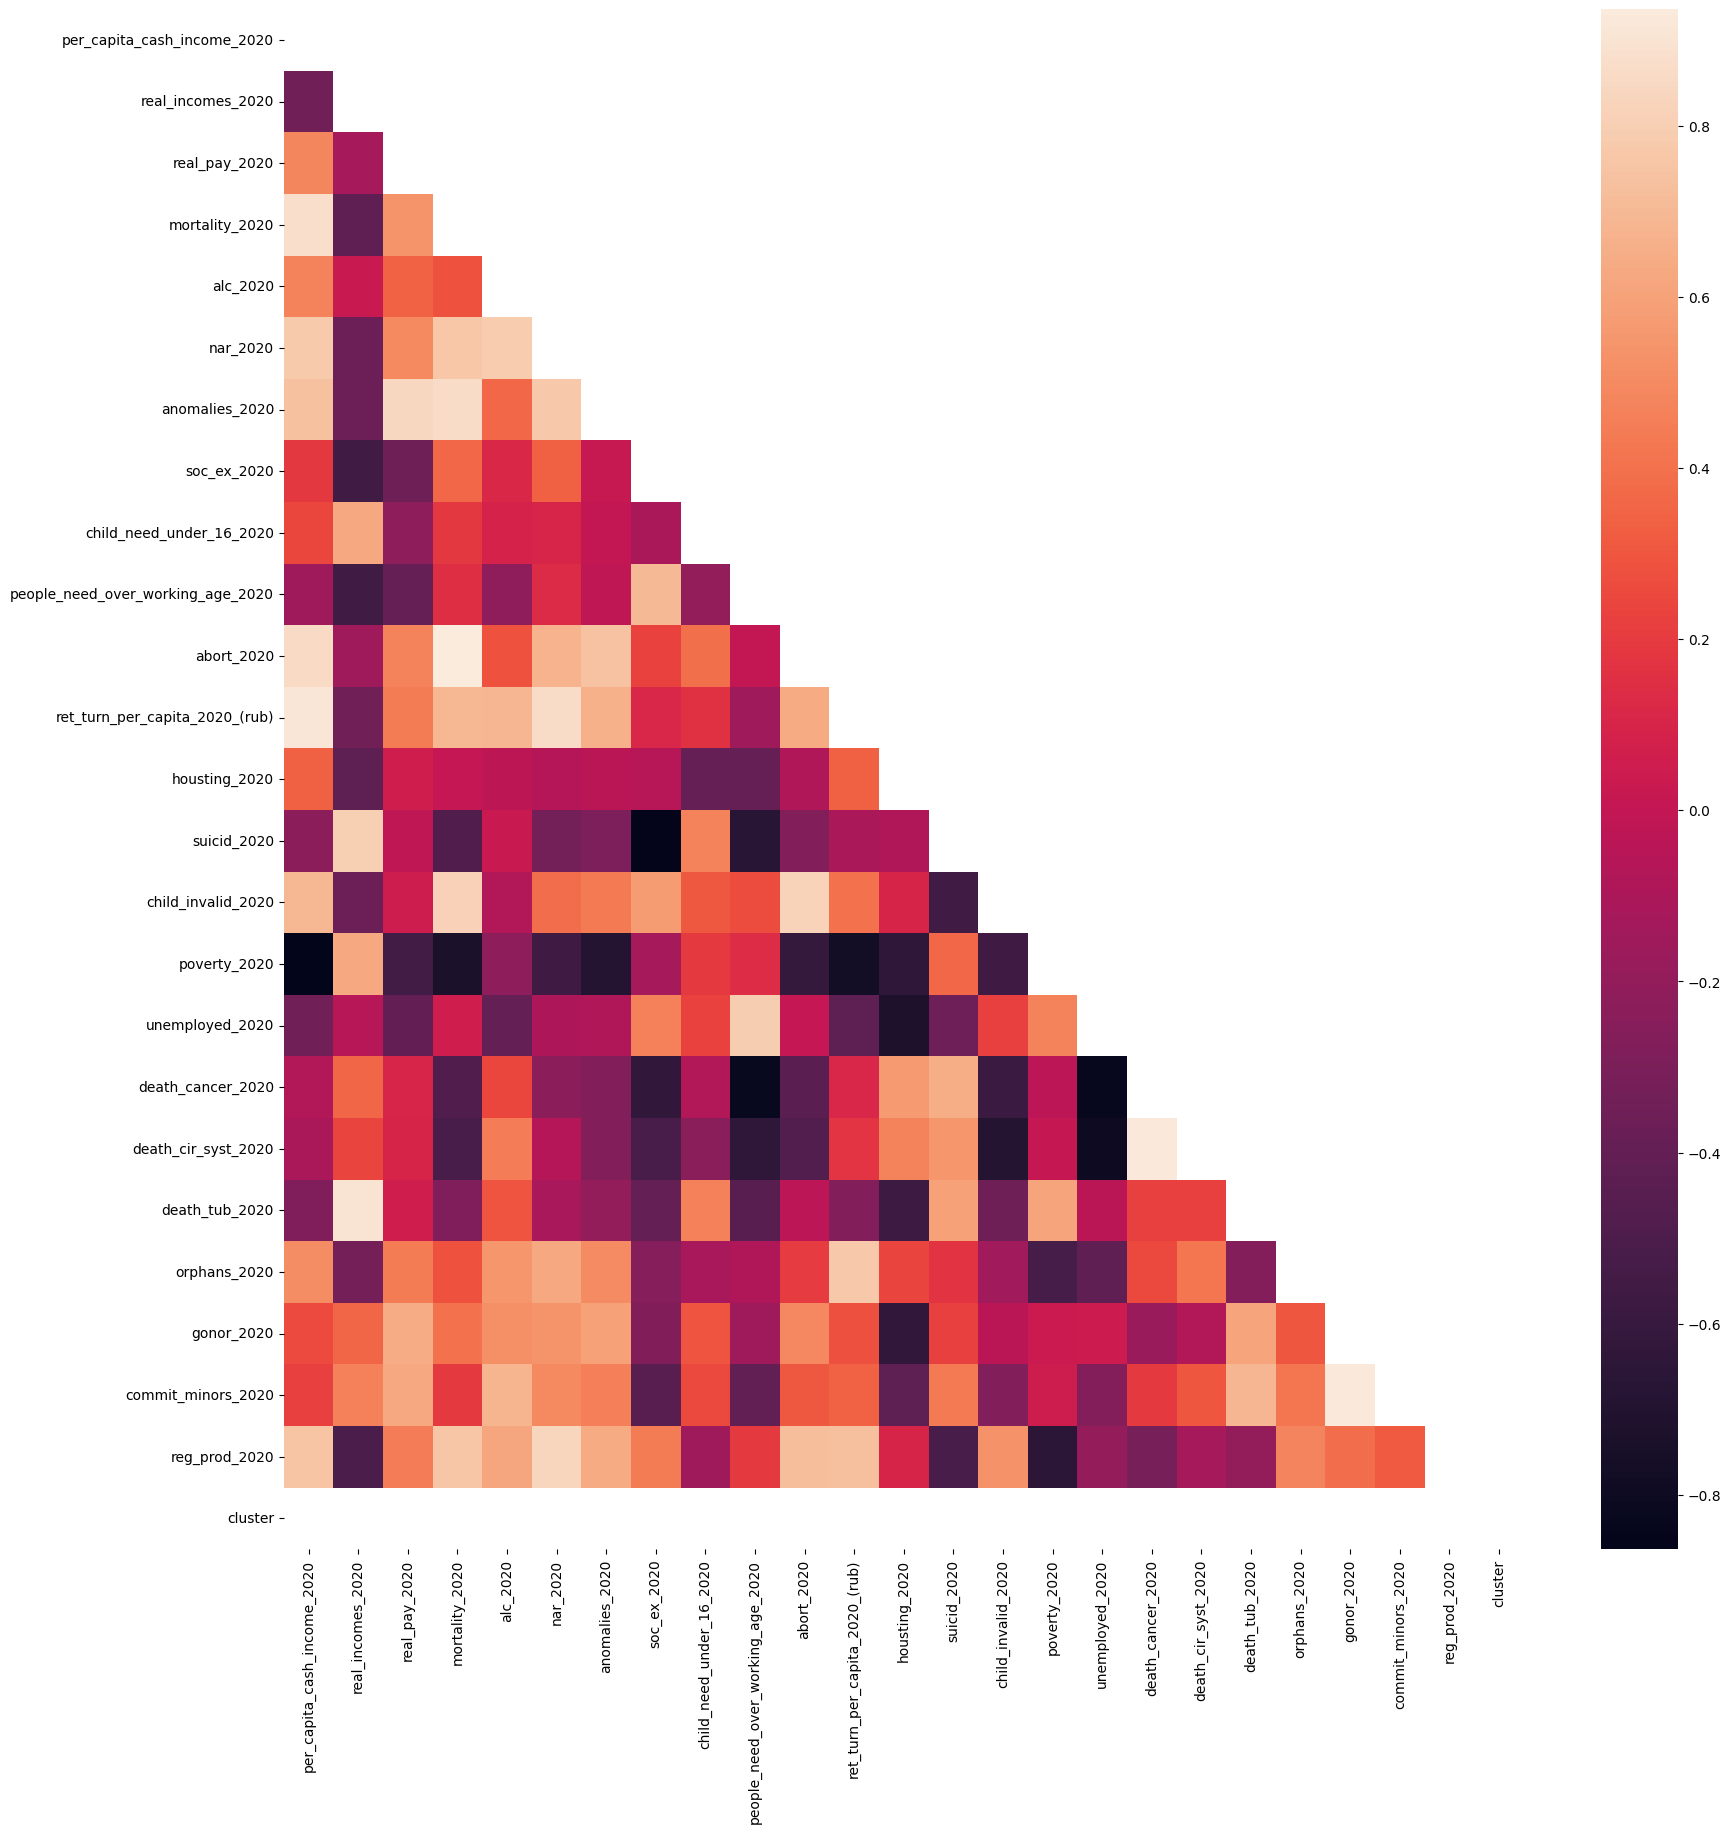

In [25]:
plt.figure(figsize=(20, 20))
matrix = np.triu(df_3.corr())
sns.heatmap(df_3.corr(), annot=True, mask=matrix)

В третий кластер попали регионы в большинстве своем с мусульманским населением. Поэтому наблюдаются специфические особенности менталитета.
Проблемы, на которые стоит обратить Заказчику  внимание: 
* Достаток в средствах приводит к т.н. "европеизации"  уклада жизни: допущение злоупотребления алкоголем, потребления наркотических средств, одобрение абортов в будущем, в итоге приводит к ухудшению ситуации с рождаемостью (повышена смертность, рождение детей с врожденными аномалиями, рождение детей-инвалидов, появление сирот). Так же немал процент суицида, что тоже является больше европейской чертой. 
* Алкоголизм приводит к появлению классических болезней сердечно-сосудистой системы, повышает риск заражению гонореей.
* Наблюдается интересная тенденция: достаточно высокий доход не снижает риски появления молодых преступников: наоборот наблюдается рост преступности "золотой" молодежи.


Теперь можно посмотреть на соотношение этих же признаков во всех кластерах одновременно и оценить положение четвертого кластера-Москвы (которая часто называется государством в государстве)

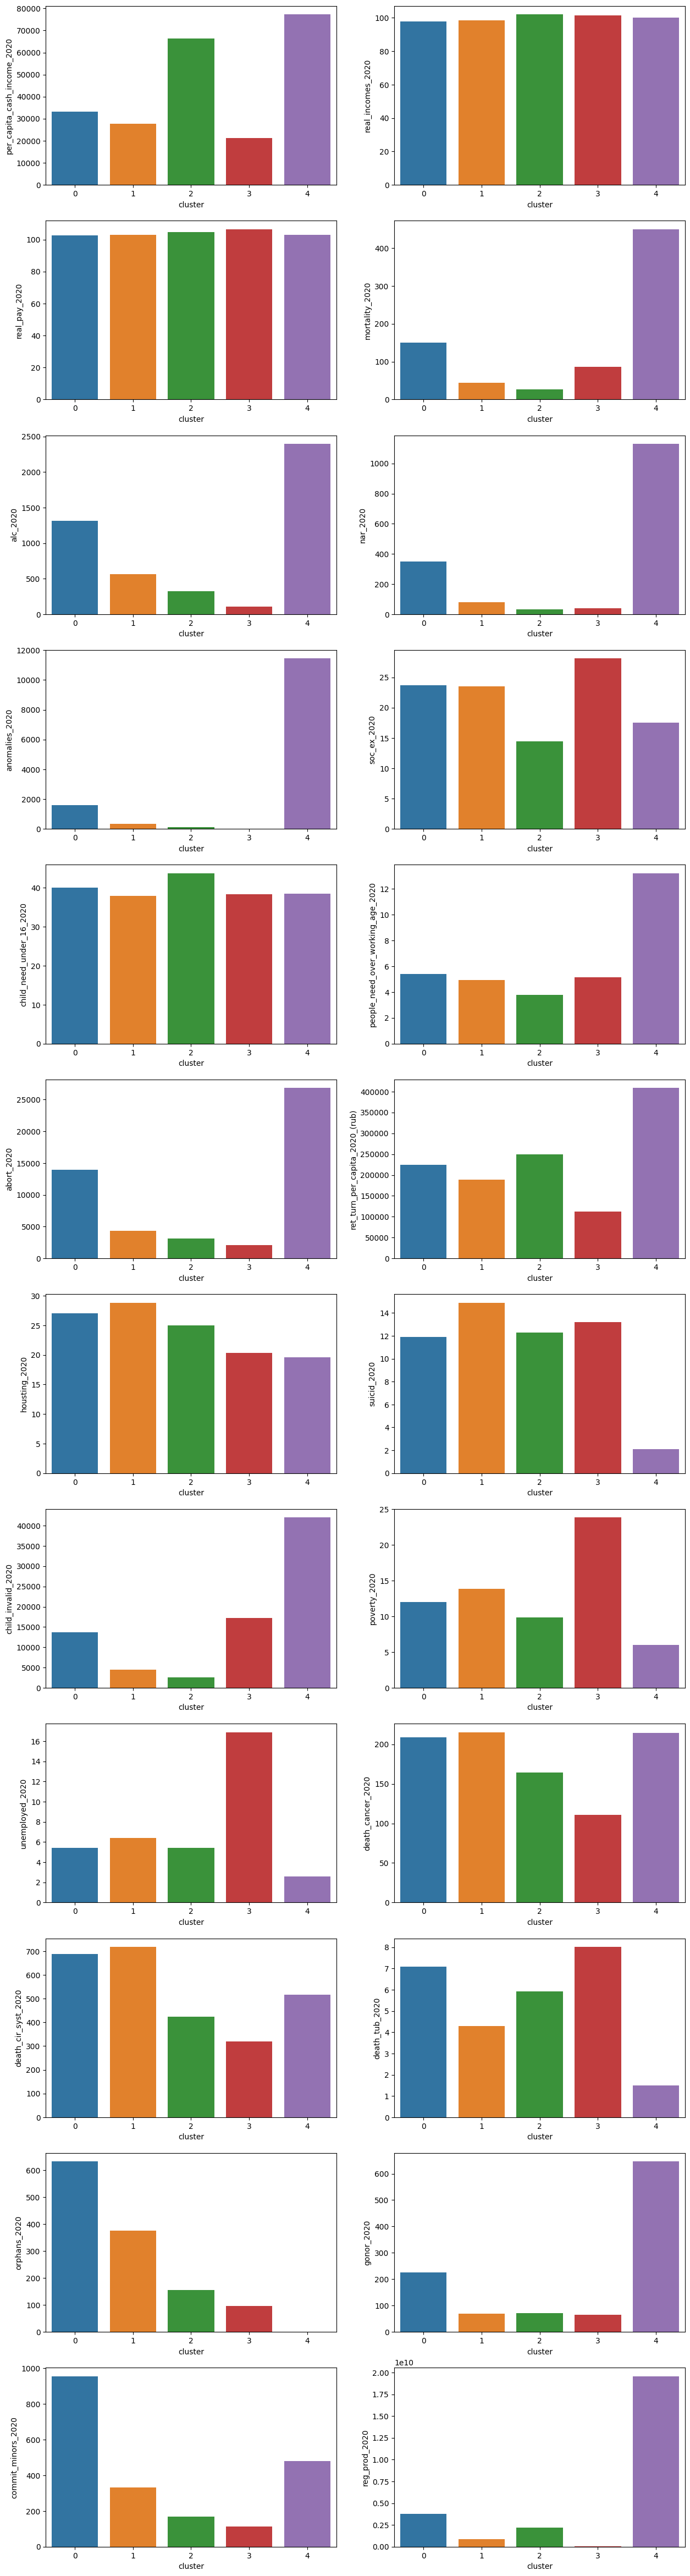

In [27]:
fig, axes = plt.subplots(12, 2, figsize=(15,60))

sns.barplot(data=social_1, x='cluster', y='per_capita_cash_income_2020', ax=axes[0,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='real_incomes_2020', ax=axes[0,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='real_pay_2020', ax=axes[1,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='mortality_2020', ax=axes[1,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='alc_2020', ax=axes[2,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='nar_2020', ax=axes[2,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='anomalies_2020', ax=axes[3,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='soc_ex_2020', ax=axes[3,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='child_need_under_16_2020', ax=axes[4,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='people_need_over_working_age_2020', ax=axes[4,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='abort_2020', ax=axes[5,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='ret_turn_per_capita_2020_(rub)', ax=axes[5,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='housting_2020', ax=axes[6,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='suicid_2020', ax=axes[6,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='child_invalid_2020', ax=axes[7,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='poverty_2020', ax=axes[7,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='unemployed_2020', ax=axes[8,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='death_cancer_2020', ax=axes[8,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='death_cir_syst_2020', ax=axes[9,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='death_tub_2020', ax=axes[9,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='orphans_2020', ax=axes[10,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='gonor_2020', ax=axes[10,1],ci=None)
sns.barplot(data=social_1, x='cluster', y='commit_minors_2020', ax=axes[11,0],ci=None)
sns.barplot(data=social_1, x='cluster', y='reg_prod_2020', ax=axes[11,1],ci=None)
plt.show();


*Каковы выводы по кластерам?*

Необходимо в первую очередь направить денежные средства и разработать адаптационную психологическую помощь по следующим направлениям для следующих кластеров:
* детская смертность, детская инвалидизация, алкоголизм, наркомания, аборты (добровольные и по показаниям), уровень заболеваемости гонореей, онкологическими заболеваниями, рождение детей с врожденными аномалиями, дополнительная помощь нуждающимся пенсионерам  - 4й кластер
* соцподдержка детям до 16 лет и в целом на каждый регион требуется жителям регионов 2 кластера
* максимальный уровень заболеваний сердечно-сосудистой системы, уровень случаев суицида - 1 кластер
* смертность от туберкулеза, число безработных, а также проживающих за чертой бедности - 3 кластер
* дети-инвалиды и высокий уровень преступности среди детей, не достигших 16 лет - 0 кластер


***Как бы ни стремились в Москву, она не отличается высокими положительными показателями, что подтверждается приезжающими на заработки в столицу лично. Москва требует полной отдачи, иногда жертв в личной жизни, даже за счет абортов и переработок ради заработка  :)***

Для моделей кластеризации не существует меры точности, поскольку нет целевой переменной, по которой можно было бы измерить точность. 
Наиболее распространенными способами измерения производительности моделей кластеризации являются либо измерение отличия, либо сходство между созданными группами. 
Попробуем посчитать метрики качества 3 способами: 
* Индекс Калински-Харабаза
* Оценка силуэта
* Индекс Дэвиса-Булдина

In [44]:
X=scaled_df

In [45]:
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.calinski_harabasz_score(X, labels)

17.301011383686546

In [46]:
kmeans_model = KMeans(n_clusters=5, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.2226949975979621

In [47]:
kmeans = KMeans(n_clusters=5, random_state=1).fit(X)
labels = kmeans.labels_
davies_bouldin_score(X, labels)

1.2257290165795944

попробуем снизить размерность и проверим метриками

In [35]:
pca = PCA(n_components=0.9, svd_solver='full')
pca_df = pca.fit_transform(scaled_df)

In [36]:
X=pca_df

In [37]:
metrics.calinski_harabasz_score(X, labels)

20.600407870135278

In [38]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.2488257681094089

In [39]:
davies_bouldin_score(X, labels)

1.1160313540448012

после снижения размерности метрики немного улучшились, но незначительно

****Резюме****


Таковы результаты анализа показателей социального не/благополучия на 2020 год. Для более детального прогноза следует провести изучение показателей за минимум 5 лет, предшествующих дате заказа исследования для выявления скрытых тенденций с целью разработки превентивных мер помощи людям, могущих оказаться на критическом уровне показателей.